# Investigation of Trip Data from Bay Area Bike Share Published Data

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import scipy
import math
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime

import seaborn as sns
# sns.set()
sns.set_style('whitegrid')
sns.set_context("poster")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 10

# Load Trip Data

In [3]:
print('[%s] Loading Trip Data Data...' % datetime.datetime.now().time())

trips_df = pd.DataFrame()
trip_data_file = '../clean_data/bayareabikeshare/trip_data_extended_cleaned.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(trip_data_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(trip_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['start_date', 'end_date', 'forecast_time']):
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

trips_df = pd.concat(chunks)
trips_df.user_type = trips_df.user_type.astype('category')

print('[%s] Complete!' % datetime.datetime.now().time())


[15:25:11.252955] Loading Trip Data Data...
		[15:25:14.283166] finished chunk 1 of 96
		[15:25:17.969507] finished chunk 10 of 96
		[15:25:20.305610] finished chunk 20 of 96
		[15:25:22.266942] finished chunk 30 of 96
		[15:25:24.216528] finished chunk 40 of 96
		[15:25:26.118732] finished chunk 50 of 96
		[15:25:28.021700] finished chunk 60 of 96
		[15:25:29.892993] finished chunk 70 of 96
		[15:25:31.765503] finished chunk 80 of 96
		[15:25:33.650422] finished chunk 90 of 96
		[15:25:34.649597] finished chunk 96 of 96
[15:25:35.609904] Complete!


In [4]:
trips_df.head(5)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,humidity,precipIntensity,precipProbability,precipType,pressure,temperature,forecast_time,visibility,windBearing,windSpeed
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,0.92,0.0,0.0,0.0,1017.06,62.63,2013-08-29 09:00:00,10.0,183.0,0.7
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,0.91,0.0,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,0.91,0.0,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,...,0.91,0.0,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,...,0.91,0.0,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0


In [5]:
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 955557 entries, 0 to 1052961
Data columns (total 37 columns):
trip_id                    955557 non-null int64
duration                   955557 non-null int64
start_date                 955557 non-null datetime64[ns]
start_station_name         955557 non-null object
start_terminal             955557 non-null int64
end_date                   955557 non-null datetime64[ns]
end_station_name           955557 non-null object
end_terminal               955557 non-null int64
bike_id                    955557 non-null int64
user_type                  955557 non-null category
user_zip                   955557 non-null int64
duration_minutes           955557 non-null float64
start_zip                  955557 non-null int64
start_elevation_meters     955557 non-null float64
start_elevation_feet       955557 non-null float64
end_zip                    955557 non-null int64
end_elevation_meters       955557 non-null float64
end_elevation_feet      

## Utility Functions

In [6]:
def zip_to_landmark(zip_code):
    ''' Return zipcode for given landmark'''
    if zip_code == 94107:
        return 'San Francisco'
    if zip_code == 94063:
        return 'Redwood City'
    if zip_code == 94301:
        return 'Palo Alto'
    if zip_code == 94041:
        return 'Mountain View'
    if zip_code == 95113:
        return 'San Jose'
    return False

In [7]:
day_labels = ['MON','TUE','WED','THU','FRI','SAT','SUN']
day_labels_full = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
month_labels = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

# Analysis 1 - Usage by Region

<ul>
    <li>How many Trips are taken within each region?</li>
    <li>How many Trips are taken within each region by user type?</li>
    <li>How many Trips are taken that cross from one rgion to another?</li>
</ul>

In [8]:
ordered_zipcodes = [94107, 95113, 94041, 94301, 94063]

print('\t\t\t\t\t\t\t\tSubscriber\tSubscriber\tCustomer\tCustomer')
print('\t\tRegion\t\tTrip Count\tTrip Share\tTrip Count\tRegion Share\tTrip Count\tRegion Share')

# data for all trip
babs_label='Full Service Area'
babs_trip_count            = trips_df.trip_id.count()
babs_trip_count_subscriber = trips_df[trips_df.user_type == 'Subscriber'].trip_id.count()
babs_trip_share_subscriber = babs_trip_count_subscriber / trips_df.trip_id.count() * 100.
babs_trip_share_subscriber = '{:2.4f}'.format(babs_trip_share_subscriber).rjust(6)

babs_trip_count_customer   = trips_df[trips_df.user_type == 'Customer'].trip_id.count()
babs_trip_share_customer   = babs_trip_count_customer / trips_df.trip_id.count() * 100.
babs_trip_share_customer = '{:2.4f}'.format(babs_trip_share_customer).rjust(6)

print('%s\t\t%s\t%s\t%s\t%s\t%s\t%s' % (babs_label.rjust(20), 
                                        str(babs_trip_count).rjust(10), 
                                        str('100.0000').rjust(10), 
                                        str(babs_trip_count_subscriber).rjust(10), 
                                        str(babs_trip_share_subscriber).rjust(10), 
                                        str(babs_trip_count_customer).rjust(10), 
                                        str(babs_trip_share_customer).rjust(10)))


for zip_code in ordered_zipcodes:

        
    # subset All Days
    trips_in_zip            = trips_df[(trips_df.start_zip == zip_code) & (trips_df.end_zip == zip_code)]
    subscriber_trips_in_zip = trips_in_zip[trips_in_zip.user_type == 'subscriber'.title()]
    customer_trips_in_zip   = trips_in_zip[trips_in_zip.user_type == 'customer'.title()]
    
    # subset Weekend Only
    weekend_trips_in_zip            =     trips_in_zip[trips_in_zip.start_date.dt.dayofweek < 5]
    weekend_subscriber_trips_in_zip =     subscriber_trips_in_zip[subscriber_trips_in_zip.start_date.dt.dayofweek < 5]
    weekend_customer_trips_in_zip   =     customer_trips_in_zip[customer_trips_in_zip.start_date.dt.dayofweek < 5]
    
    # subset Weekdays Only
    weekday_trips_in_zip            =     trips_in_zip[trips_in_zip.start_date.dt.dayofweek >= 5]
    weekday_subscriber_trips_in_zip =     subscriber_trips_in_zip[subscriber_trips_in_zip.start_date.dt.dayofweek >= 5]
    weekday_customer_trips_in_zip   =     customer_trips_in_zip[customer_trips_in_zip.start_date.dt.dayofweek >= 5]
    
    # format All Days
    trips_in_zip_count = trips_in_zip.shape[0]

    trips_in_zip_share = trips_in_zip.shape[0] / trips_df.shape[0] * 100.
    trips_in_zip_share = '{:2.4f}'.format(trips_in_zip_share)
    
    subscriber_trips_in_zip_count = subscriber_trips_in_zip.shape[0]

    subscriber_trips_in_zip_share = subscriber_trips_in_zip.shape[0] / trips_in_zip.shape[0] * 100.
    subscriber_trips_in_zip_share = '{:2.4f}'.format(subscriber_trips_in_zip_share)
    
    customer_trips_in_zip_count = customer_trips_in_zip.shape[0]

    customer_trips_in_zip_share = customer_trips_in_zip.shape[0] / trips_in_zip.shape[0] * 100.
    customer_trips_in_zip_share = '{:2.4f}'.format(customer_trips_in_zip_share)
    
    
    print('%s\t\t%s\t%s\t%s\t%s\t%s\t%s' % (zip_to_landmark(zip_code).rjust(20), 
                                            str(trips_in_zip_count).rjust(10), 
                                            str(trips_in_zip_share).rjust(10), 
                                            str(subscriber_trips_in_zip_count).rjust(10), 
                                            str(subscriber_trips_in_zip_share).rjust(10), 
                                            str(customer_trips_in_zip_count).rjust(10), 
                                            str(customer_trips_in_zip_share).rjust(10)))
    
# cross region trips
cross_region_trips = trips_df[trips_df.start_zip != trips_df.end_zip]

cross_region_label='Cross Region'
cross_region_trip_count = cross_region_trips.trip_id.count()

cross_region_trip_share = cross_region_trips.shape[0] / trips_df.shape[0] * 100.
cross_region_trip_share = '{:2.4f}'.format(cross_region_trip_share)

cross_region_trip_count_subscriber = cross_region_trips[cross_region_trips.user_type == 'Subscriber'].trip_id.count()
cross_region_trip_share_subscriber = cross_region_trip_count_subscriber / cross_region_trips.trip_id.count() * 100.
cross_region_trip_share_subscriber = '{:2.4f}'.format(cross_region_trip_share_subscriber).rjust(6)

cross_region_trip_count_customer   = cross_region_trips[cross_region_trips.user_type == 'Customer'].trip_id.count()
cross_region_trip_share_customer   = cross_region_trip_count_customer / cross_region_trips.trip_id.count() * 100.
cross_region_trip_share_customer = '{:2.4f}'.format(cross_region_trip_share_customer).rjust(6)

print('%s\t\t%s\t%s\t%s\t%s\t%s\t%s' % (cross_region_label.rjust(20), 
                                        str(cross_region_trip_count).rjust(10), 
                                        str(cross_region_trip_share).rjust(10), 
                                        str(cross_region_trip_count_subscriber).rjust(10), 
                                        str(cross_region_trip_share_subscriber).rjust(10), 
                                        str(cross_region_trip_count_customer).rjust(10), 
                                        str(cross_region_trip_share_customer).rjust(10)))

								Subscriber	Subscriber	Customer	Customer
		Region		Trip Count	Trip Share	Trip Count	Region Share	Trip Count	Region Share
   Full Service Area		    955557	  100.0000	    844570	   88.3851	    110987	   11.6149
       San Francisco		    868208	   90.8588	    769677	   88.6512	     98531	   11.3488
            San Jose		     51012	    5.3385	     43978	   86.2111	      7034	   13.7889
       Mountain View		     23012	    2.4082	     20620	   89.6054	      2392	   10.3946
           Palo Alto		      7591	    0.7944	      5530	   72.8494	      2061	   27.1506
        Redwood City		      4581	    0.4794	      4075	   88.9544	       506	   11.0456
        Cross Region		      1153	    0.1207	       690	   59.8439	       463	   40.1561


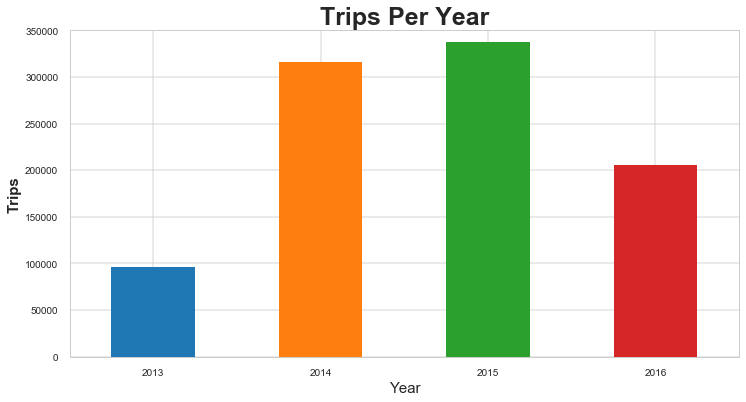

In [9]:
# Trips per year

trips_per_year_df = pd.DataFrame()

trips_per_year_df['trips'] = trips_df.groupby(trips_df.start_date.dt.year)['trip_id'].count().transpose()
trips_per_year_df.reset_index(inplace=True)
trips_per_year_df.rename(columns={'start_date':'year'}, inplace=True)

months_per_year = pd.Series([5, 12, 12, 8])
trips_per_year_df['months_per_year'] = months_per_year
trips_per_year_df['trips_adj'] = trips_per_year_df['trips'] * (12/ trips_per_year_df['months_per_year'])

ax = trips_per_year_df['trips'].plot(kind='bar', figsize=(12,6))
ax.set_xticklabels(trips_per_year_df['year'], rotation=0, size=TICK_FONT_SIZE)
ax.set_xlabel('Year', size=LABEL_FONT_SIZE)

y_tick_interval = 50000
y_max = trips_per_year_df['trips'].max()
y_max = math.ceil(y_max/y_tick_interval) * y_tick_interval
ax.set_ylim([0, y_max])
ax.set_yticks([y*y_tick_interval for y in np.arange(y_max/y_tick_interval + 1)])
ax.set_yticklabels([str(int(y*y_tick_interval)) for y in np.arange(y_max/y_tick_interval + 1)], size=TICK_FONT_SIZE)

ax.set_title('Trips Per Year', size=TITLE_FONT_SIZE, weight='bold')
ax.set_ylabel('Trips', size=LABEL_FONT_SIZE, weight='bold')


ax.grid(alpha=0.5)
plt.show()

Subscriber Mean Trips  23434.7222
Subscriber Range Trips 7020.5000
Customer Mean Trips    3055.8889
Customer Range Trips   3482.5000


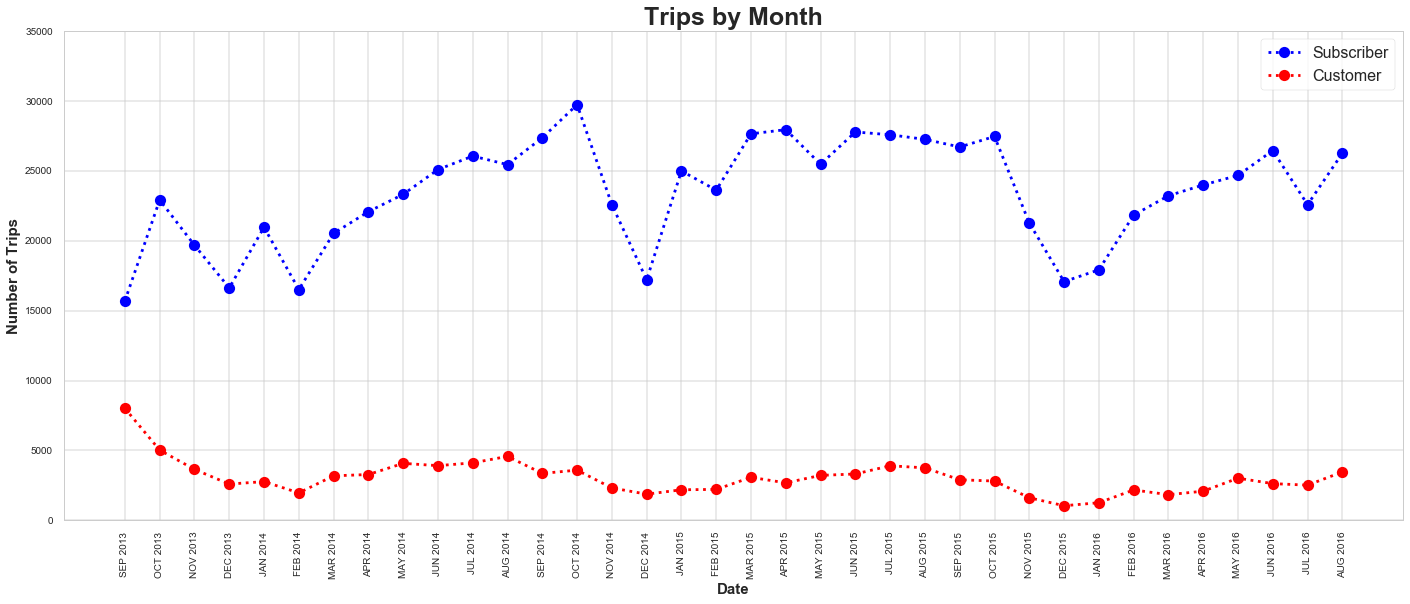

In [10]:
trips_per_month_df = pd.DataFrame()

y_max = -np.inf

for user_type in sorted(pd.unique(trips_df.user_type), reverse=True):
    t = trips_df[~((trips_df.start_date.dt.year == 2013) & (trips_df.start_date.dt.month == 8))]
    trips_per_month_df = t[t.user_type == user_type].groupby([t.start_date.dt.year, t.start_date.dt.month])['trip_id'].count().transpose()
    
    if trips_per_month_df.max() > y_max:
        y_max = trips_per_month_df.max()
    
    if user_type == 'Subscriber':
        print('Subscriber Mean Trips  {:6.4f}'. format(trips_per_month_df.mean()))
        print('Subscriber Range Trips {:6.4f}'. format((trips_per_month_df.max() - trips_per_month_df.min()) / 2.0))
        ax = trips_per_month_df.plot(linestyle=':', marker='o', figsize=(24,9), label=user_type, color='b')
    if user_type == 'Customer':
        print('Customer Mean Trips    {:6.4f}'. format(trips_per_month_df.mean()))
        print('Customer Range Trips   {:6.4f}'. format((trips_per_month_df.max() - trips_per_month_df.min()) / 2.0))
        ax = trips_per_month_df.plot(linestyle=':', marker='o', figsize=(24,9), label=user_type, color='r')
        

        

xticklabels = []
for year in sorted(pd.unique(t.start_date.dt.year)):
    for month in sorted(pd.unique(t[t.start_date.dt.year == year].start_date.dt.month)):
        
        tick_label = '%s %s' % (month_labels[month-1], year)
        xticklabels.append(tick_label)

ax.set_xticks(range(0, trips_per_month_df.shape[0]))
ax.set_xticklabels(xticklabels, rotation=90, size=TICK_FONT_SIZE)
ax.set_xlabel('Date', size=LABEL_FONT_SIZE, weight='bold')

y_tick_interval = 5000
y_max = math.ceil(y_max/y_tick_interval) * y_tick_interval + y_tick_interval
ax.set_ylim([0, y_max])
ax.set_yticks([y*y_tick_interval for y in np.arange(y_max/y_tick_interval + 1)])
ax.set_yticklabels([str(int(y*y_tick_interval)) for y in np.arange(y_max/y_tick_interval + 1)], size=TICK_FONT_SIZE)
ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')

ax.grid(alpha=0.5)
    
ax.legend(loc=1, frameon=True)
title = 'Trips by Month'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

image_title = '../charts/investigation_trips/Investigation_%s.png' % title.replace(' ', '_')
plt.savefig(image_title)

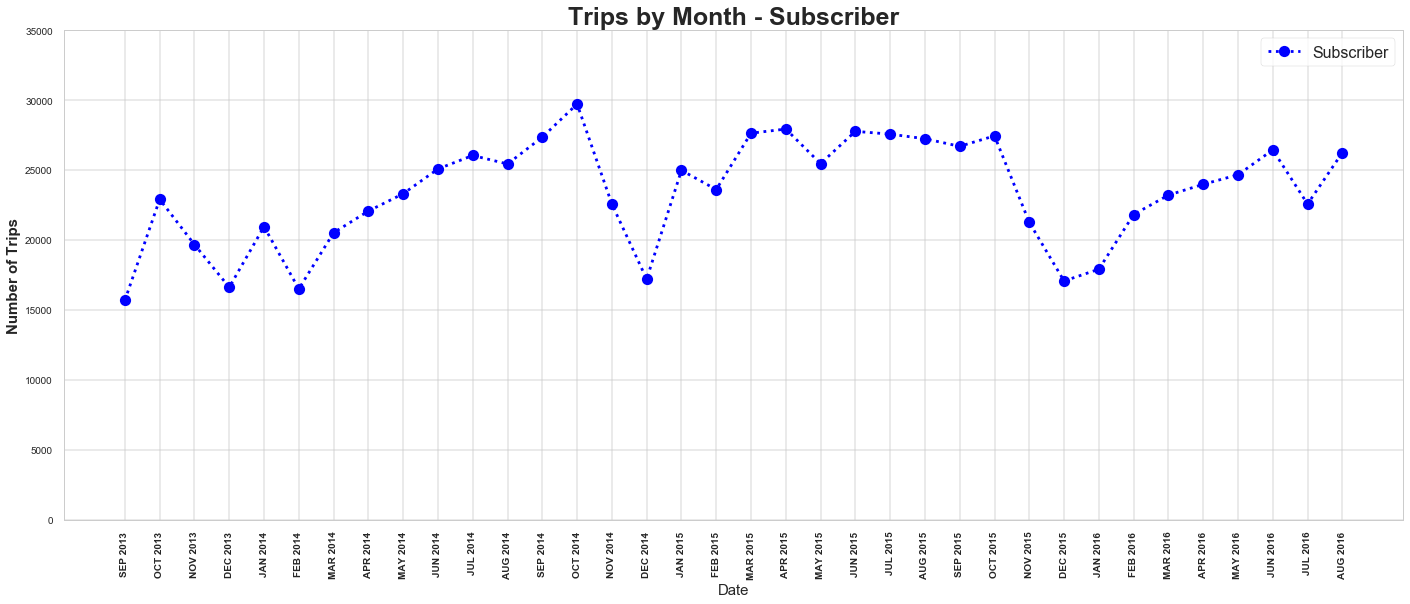

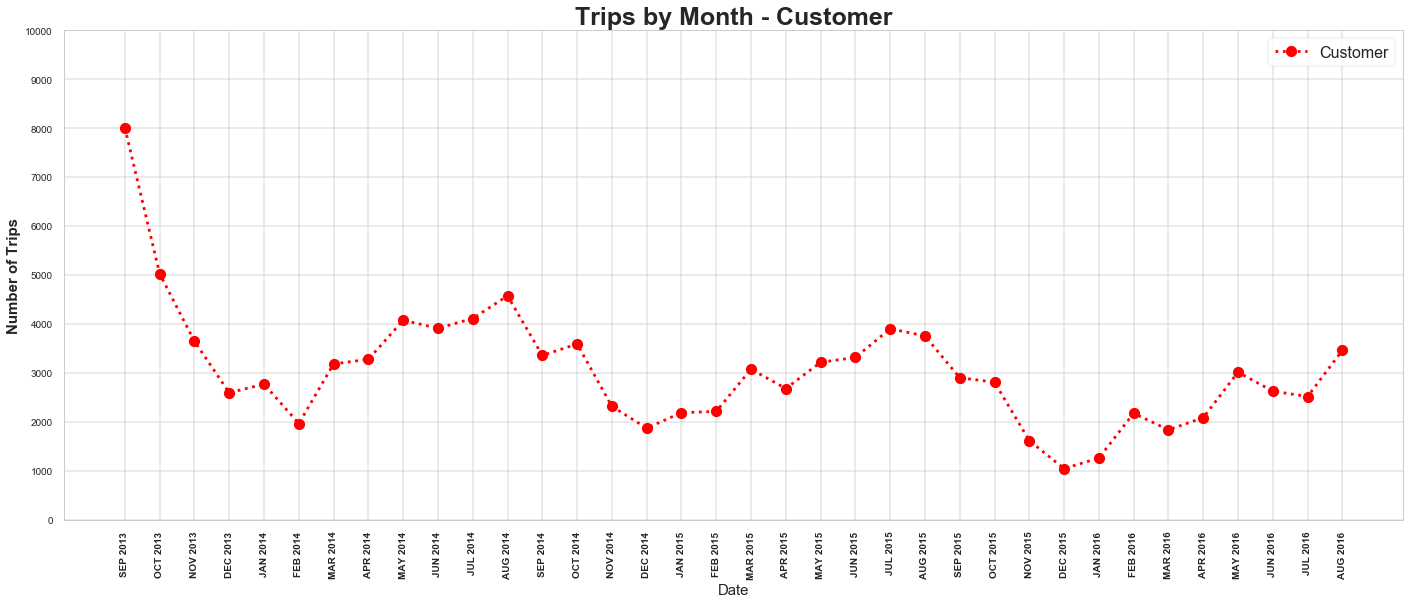

In [11]:
trips_per_month_df = pd.DataFrame()

for user_type in sorted(pd.unique(trips_df.user_type), reverse=True):
    y_max = -np.inf
    
    t = trips_df[~((trips_df.start_date.dt.year == 2013) & (trips_df.start_date.dt.month == 8))]
    trips_per_month_df = t[t.user_type == user_type].groupby([t.start_date.dt.year, t.start_date.dt.month])['trip_id'].count().transpose()
    
    if trips_per_month_df.max() > y_max:
        y_max = trips_per_month_df.max()

    
    
    
    if user_type == 'Subscriber':
        ax = trips_per_month_df.plot(linestyle=':', marker='o', figsize=(24,9), label=user_type, color='b')
    if user_type == 'Customer':
        ax = trips_per_month_df.plot(linestyle=':', marker='o', figsize=(24,9), label=user_type, color='r')
    
    xticklabels = []
    for year in sorted(pd.unique(t.start_date.dt.year)):
        for month in sorted(pd.unique(t[t.start_date.dt.year == year].start_date.dt.month)):



            tick_label = '%s %s' % (month_labels[month-1], year)
            xticklabels.append(tick_label)

    ax.set_xticks(range(0, trips_per_month_df.shape[0]))
    ax.set_xticklabels(xticklabels, rotation=90, size=TICK_FONT_SIZE, weight='bold')
    ax.set_xlabel('Date', size=LABEL_FONT_SIZE)
    

    if user_type == 'Subscriber':
        y_tick_interval = 5000
    if user_type == 'Customer':
        y_tick_interval = 1000

    y_max = math.ceil(y_max/y_tick_interval) * y_tick_interval + y_tick_interval
    ax.set_ylim([0, y_max])
    ax.set_yticks([y*y_tick_interval for y in np.arange(y_max/y_tick_interval + 1)])
    ax.set_yticklabels([str(int(y*y_tick_interval)) for y in np.arange(y_max/y_tick_interval + 1)], size=TICK_FONT_SIZE)
    ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')

    ax.grid(alpha=0.5)
    
    ax.legend(loc=1, frameon=True)
    title = 'Trips by Month - %s' % user_type
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    
    image_title = '../charts/investigation_trips/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)
    plt.show()

# Analysis 2 - Usage Patterns for San Francisco Subscribers

<ul>
    <li>at any given time, how many Subscirber trips are in in process?</li>
    <li>Hourly Start and End counts</li>
    <li>Day of Week Start and End counts</li>
    <li>Month of Year Start and End counts</li>
</ul>

In [12]:
subscriber_trips_df = trips_df[trips_df.user_type == 'Subscriber'].copy()

sf_subscriber_trips_df = subscriber_trips_df[(subscriber_trips_df.start_zip == 94107) & (subscriber_trips_df.end_zip == 94107)].copy()
sf_subscriber_trips_df.reset_index(inplace=True, drop=True)
sf_subscriber_trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769677 entries, 0 to 769676
Data columns (total 37 columns):
trip_id                    769677 non-null int64
duration                   769677 non-null int64
start_date                 769677 non-null datetime64[ns]
start_station_name         769677 non-null object
start_terminal             769677 non-null int64
end_date                   769677 non-null datetime64[ns]
end_station_name           769677 non-null object
end_terminal               769677 non-null int64
bike_id                    769677 non-null int64
user_type                  769677 non-null category
user_zip                   769677 non-null int64
duration_minutes           769677 non-null float64
start_zip                  769677 non-null int64
start_elevation_meters     769677 non-null float64
start_elevation_feet       769677 non-null float64
end_zip                    769677 non-null int64
end_elevation_meters       769677 non-null float64
end_elevation_feet       

In [13]:
sf_subscriber_trips_df.head()

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,humidity,precipIntensity,precipProbability,precipType,pressure,temperature,forecast_time,visibility,windBearing,windSpeed
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,0.92,0.0,0.0,0.0,1017.06,62.63,2013-08-29 09:00:00,10.0,183.0,0.7
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,0.91,0.0,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,0.91,0.0,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,...,0.91,0.0,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,...,0.91,0.0,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0


## Subscriber Trips by Hour of Day in each Region

morning commute start share    33.4546
evening commute start share    31.2683
  total commute start share    64.7229
morning commute end share      32.8646
evening commute end share      31.3926
  total commute end share      64.2572


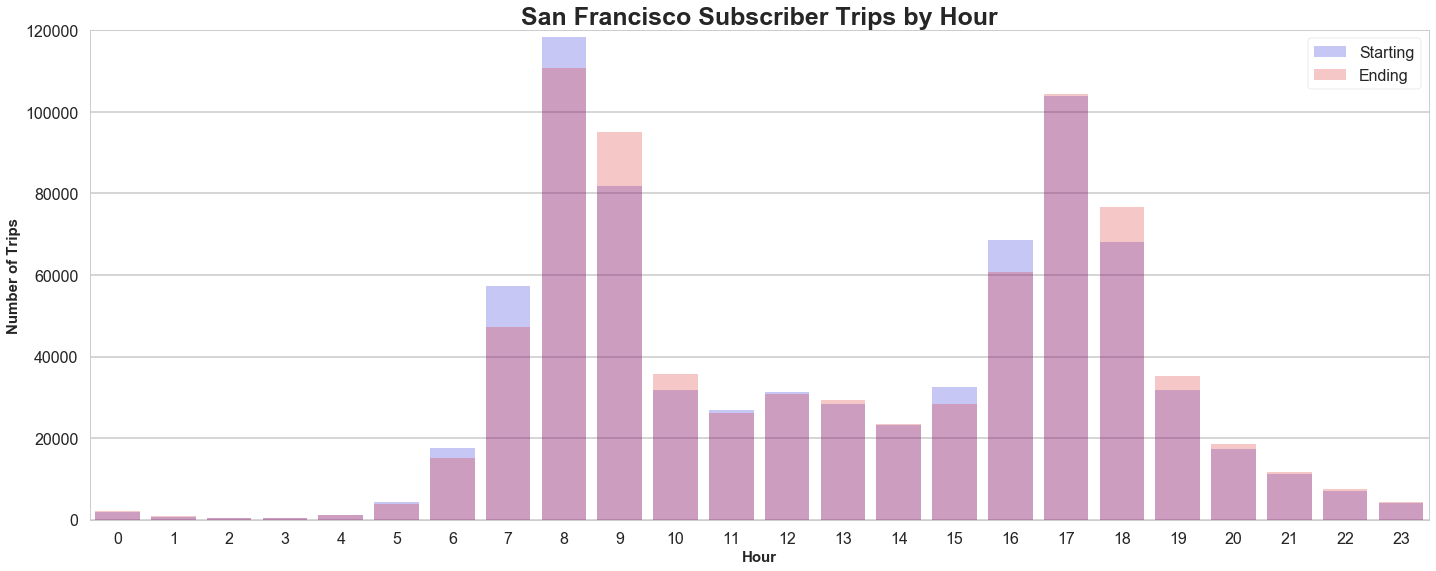

morning commute start share    26.9339
evening commute start share    33.1689
  total commute start share    60.1028
morning commute end share      27.2614
evening commute end share      33.1825
  total commute end share      60.4439


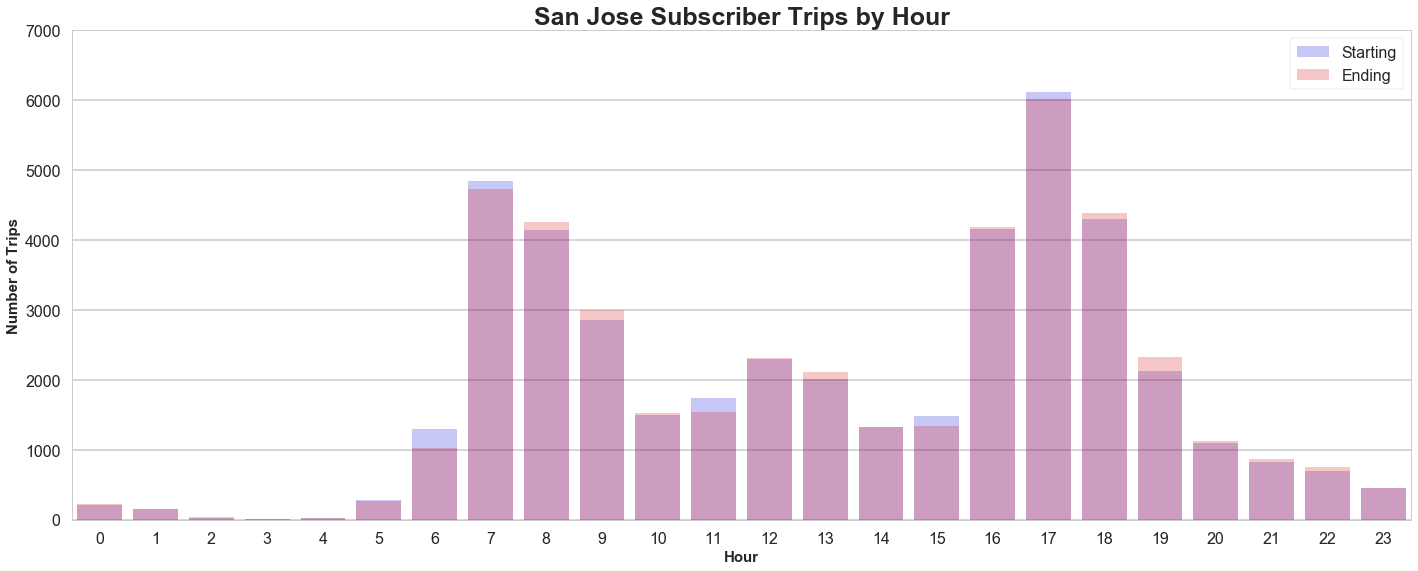

morning commute start share    39.1782
evening commute start share    36.0246
  total commute start share    75.2028
morning commute end share      38.6663
evening commute end share      35.4110
  total commute end share      74.0773


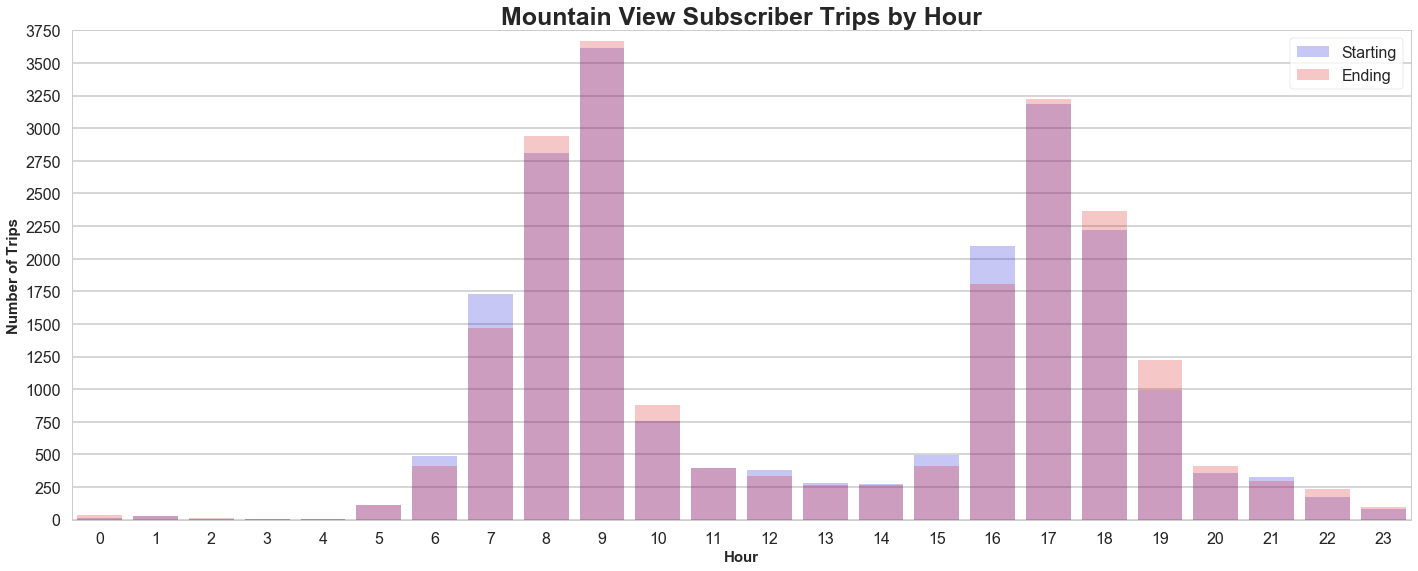

morning commute start share    35.4532
evening commute start share    33.4637
  total commute start share    68.9169
morning commute end share      34.1917
evening commute end share      33.2708
  total commute end share      67.4625


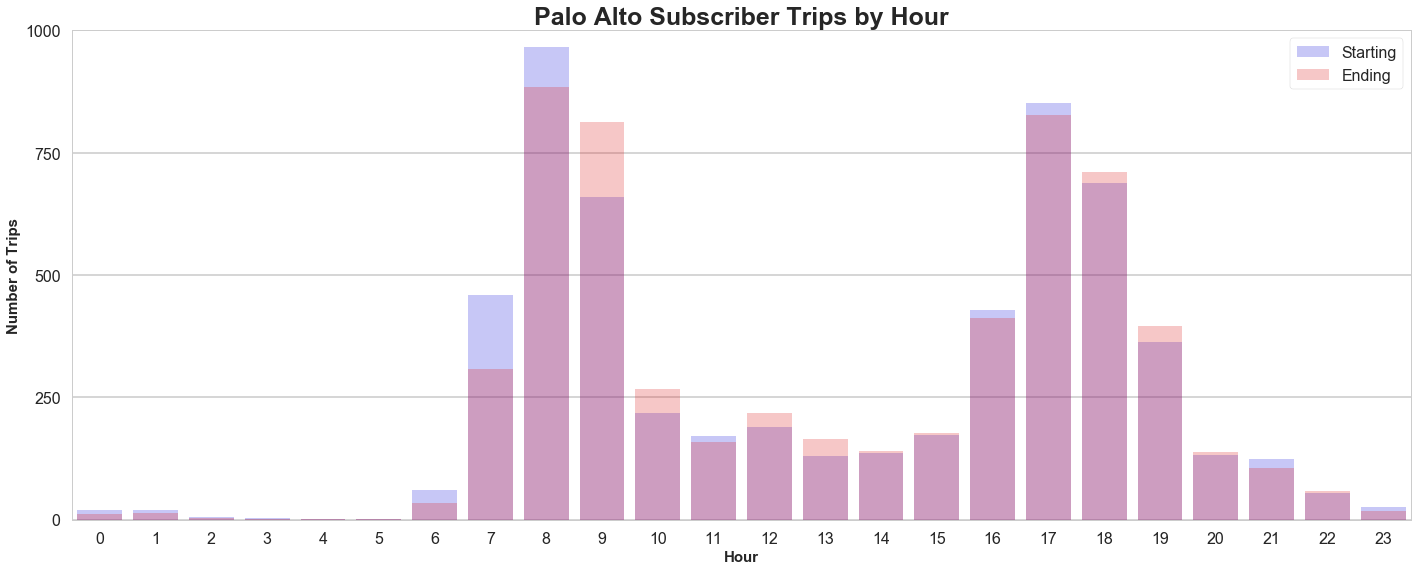

morning commute start share    35.8828
evening commute start share    33.2857
  total commute start share    69.1685
morning commute end share      37.2115
evening commute end share      31.5865
  total commute end share      68.7981


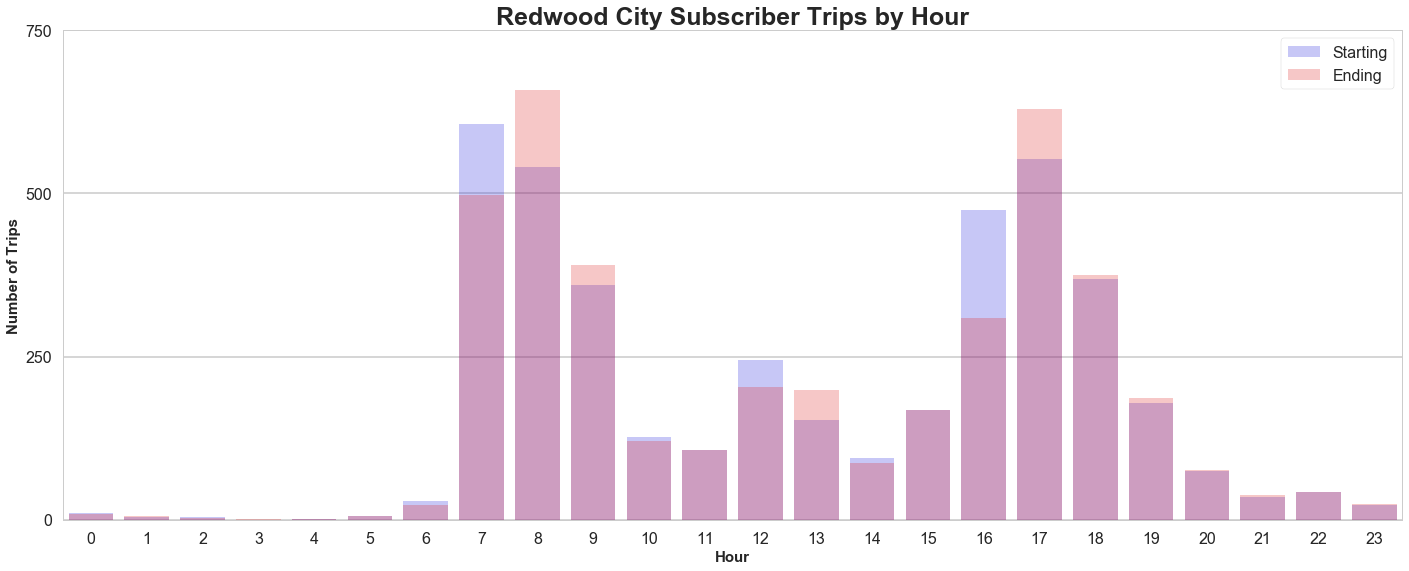

In [14]:
for zip_code in ordered_zipcodes:
    
    tmp_df = pd.DataFrame()
    
    subscriber_trips = trips_df[trips_df.user_type == 'Subscriber'].copy()
    
    starting_y = subscriber_trips[subscriber_trips.start_zip == zip_code].groupby(subscriber_trips[subscriber_trips.start_zip == zip_code].start_date.dt.hour)['trip_id'].count()
    ending_y = subscriber_trips[subscriber_trips.end_zip == zip_code].groupby(subscriber_trips[subscriber_trips.end_zip == zip_code].end_date.dt.hour)['trip_id'].count()
        
    tmp_df = pd.concat([starting_y, ending_y], axis=1)
    tmp_df = tmp_df.fillna(0)
    tmp_df.columns = ['starting', 'ending']
    tmp_df.starting = tmp_df.starting.astype('int')
    tmp_df.ending = tmp_df.ending.astype('int')
    
    tmp_df['starting_share'] = tmp_df.starting / tmp_df.starting.sum() * 100.
    tmp_df['ending_share'] = tmp_df.ending / tmp_df.ending.sum() * 100.
    
    morning_commute_start_share = tmp_df.iloc[7:10,2].sum()
    evening_commute_start_share = tmp_df.iloc[16:19,2].sum()
    commute_start_share = morning_commute_start_share + evening_commute_start_share
    print('morning commute start share    {:2.4f}'.format(morning_commute_start_share))
    print('evening commute start share    {:2.4f}'.format(evening_commute_start_share))
    print('  total commute start share    {:2.4f}'.format(commute_start_share))

    
    morning_commute_end_share = tmp_df.iloc[7:10,3].sum()
    evening_commute_end_share = tmp_df.iloc[16:19,3].sum()
    commute_end_share = morning_commute_end_share + evening_commute_end_share
    print('morning commute end share      {:2.4f}'.format(morning_commute_end_share))
    print('evening commute end share      {:2.4f}'.format(evening_commute_end_share))
    print('  total commute end share      {:2.4f}'.format(commute_end_share))

    
    x_ticks = [x for x in range(0, tmp_df.shape[0])]
    
    # Trips by Hour by Customer Type
    plt.subplots(figsize=(24,9))

    ax = sns.barplot(x = x_ticks , y = 'starting', data=tmp_df, color='b', alpha = 0.25, label='Starting')
    sns.barplot(x = x_ticks , y = 'ending', data=tmp_df, color='r', alpha = 0.25, label='Ending', ax=ax)
    
    title = '%s Subscriber Trips by Hour' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

    ax.set_xlabel('Hour', size=LABEL_FONT_SIZE, weight='bold')

    
    # set y axis
    y_interval = tmp_df.max().max()/5000
    
    if y_interval > 10:
        y_interval = 20000
    elif y_interval <= 10 and y_interval > 1:
        y_interval = 1000
    else:
        y_interval = 250

    y_max = -np.inf
    y_max = tmp_df.max().max()
    y_max = math.ceil(y_max/y_interval) * y_interval
    
    ax.set_ylim([0, y_max])
    ax.set_yticks([y for y in range(0, y_max+y_interval, y_interval)])
    ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')

    ax.legend(loc=1, frameon=True)
    
    image_title = '../charts/investigation_trips/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)
    plt.show()

## Subscriber Trips by Day of Week in each Region

weekday commute start share    97.0622
weekend commute start share    2.9378
weekday commute end share      97.0583
weekend commute end share      2.9417


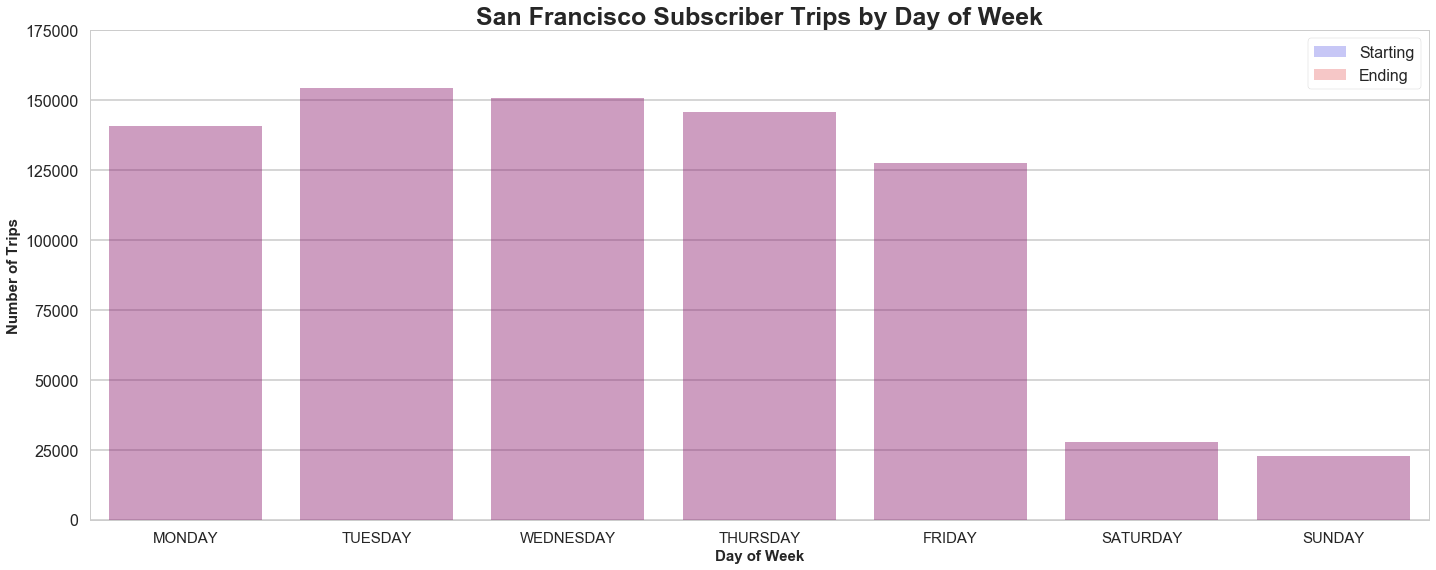

weekday commute start share    95.5432
weekend commute start share    4.4568
weekday commute end share      95.5228
weekend commute end share      4.4772


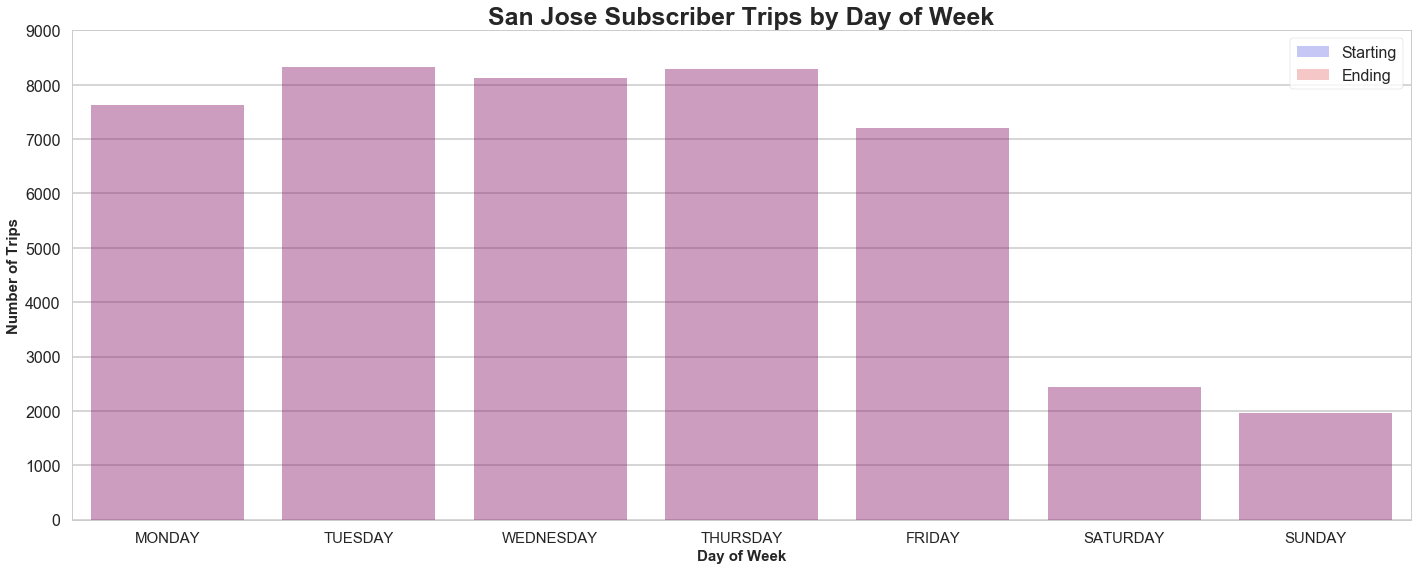

weekday commute start share    97.8016
weekend commute start share    2.1984
weekday commute end share      97.7979
weekend commute end share      2.2021


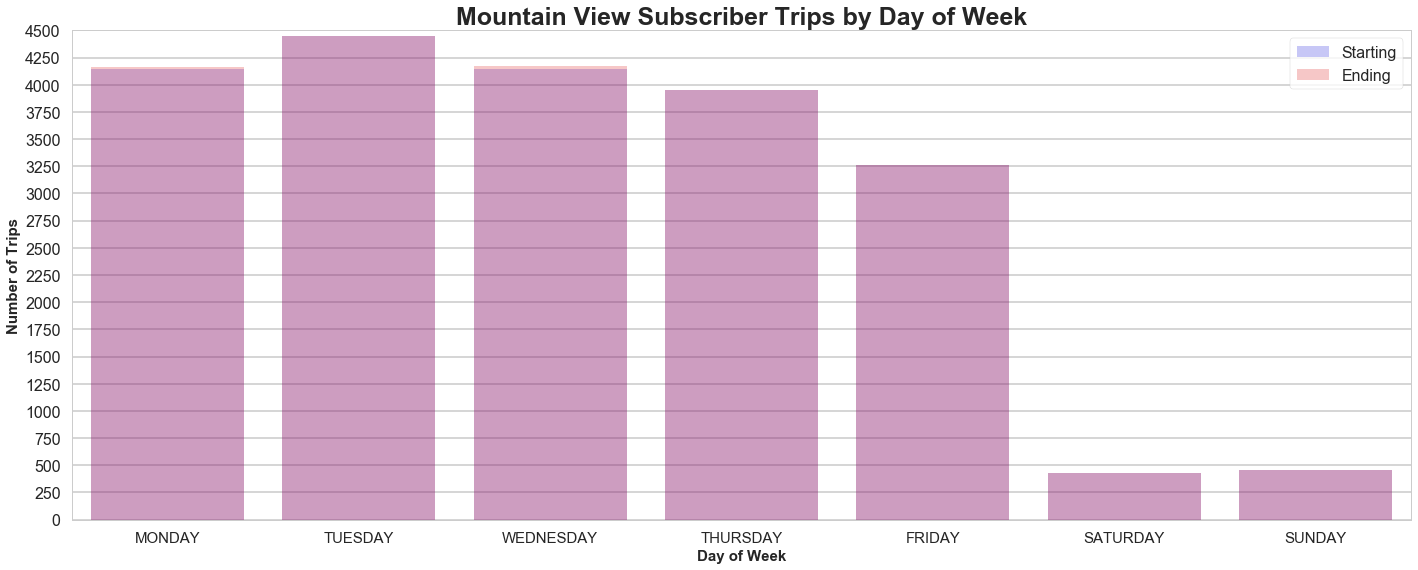

weekday commute start share    96.1911
weekend commute start share    3.8089
weekday commute end share      96.1289
weekend commute end share      3.8711


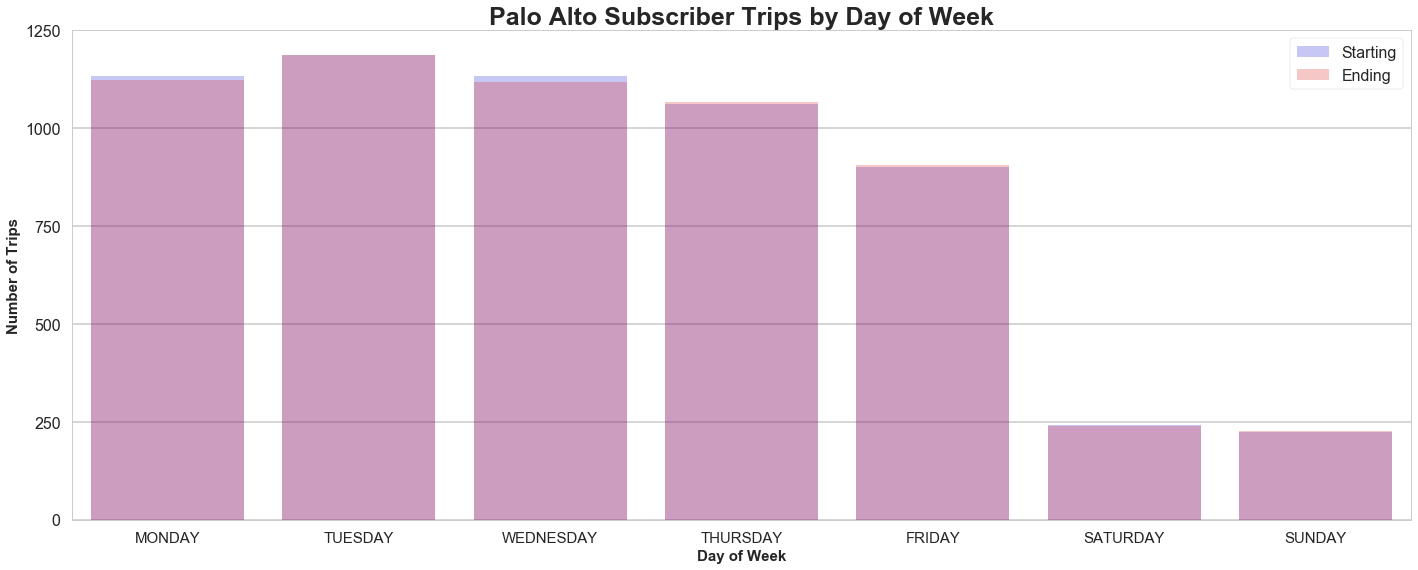

weekday commute start share    97.7365
weekend commute start share    2.2635
weekday commute end share      97.7404
weekend commute end share      2.2596


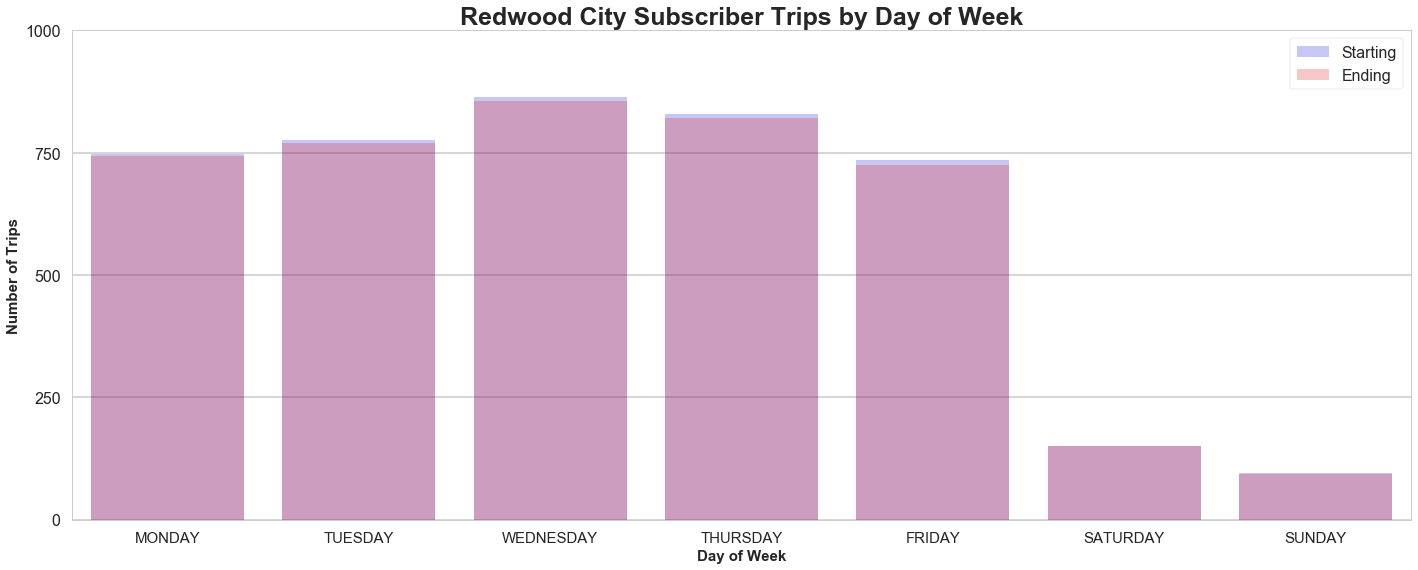

In [15]:
for zip_code in ordered_zipcodes:
    
    tmp_df = pd.DataFrame()
    
    subscriber_trips = trips_df[trips_df.user_type == 'Subscriber'].copy()
    
    starting_y = subscriber_trips[subscriber_trips.start_zip == zip_code].groupby(subscriber_trips[subscriber_trips.start_zip == zip_code].start_date.dt.dayofweek)['trip_id'].count()
    ending_y = subscriber_trips[subscriber_trips.end_zip == zip_code].groupby(subscriber_trips[subscriber_trips.end_zip == zip_code].end_date.dt.dayofweek)['trip_id'].count()
   
    tmp_df = pd.concat([starting_y, ending_y], axis=1)
    tmp_df = tmp_df.fillna(0)
    tmp_df.columns = ['starting', 'ending']
    tmp_df.starting = tmp_df.starting.astype('int')
    tmp_df.ending = tmp_df.ending.astype('int')
    
    tmp_df['starting_share'] = tmp_df.starting / tmp_df.starting.sum() * 100.
    tmp_df['ending_share'] = tmp_df.ending / tmp_df.ending.sum() * 100.
    
#     print(tmp_df[['starting_share', 'ending_share']])
    
    weekday_commute_start_share = tmp_df.iloc[0:6,2].sum()
    weekend_commute_start_share = tmp_df.iloc[6:,2].sum()
    print('weekday commute start share    {:2.4f}'.format(weekday_commute_start_share))
    print('weekend commute start share    {:2.4f}'.format(weekend_commute_start_share))

    
    weekday_commute_end_share = tmp_df.iloc[0:6,3].sum()
    weekend_commute_end_share = tmp_df.iloc[6:,3].sum()
    print('weekday commute end share      {:2.4f}'.format(weekday_commute_end_share))
    print('weekend commute end share      {:2.4f}'.format(weekend_commute_end_share))
    
    # Trips by Hour by Customer Type
    plt.subplots(figsize=(24,9))

    ax = sns.barplot(x = day_labels_full , y = 'starting', data=tmp_df, color='b', alpha = 0.25, label='Starting')
    sns.barplot(x = day_labels_full , y = 'ending', data=tmp_df, color='r', alpha = 0.25, label='Ending', ax=ax)

    
    title = '%s Subscriber Trips by Day of Week' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

    ax.set_xlabel('Day of Week', size=LABEL_FONT_SIZE, weight='bold')
    
    ax.set_xticklabels(day_labels_full, size=TICK_FONT_SIZE*1.5)
    
    # set y axis
    y_interval = tmp_df.max().max()/5000

    
    if y_interval > 30:
        y_interval = 25000
    elif y_interval < 10  and y_interval > 1:
        y_interval = 1000
    else:
        y_interval = 250
        
    y_max = -np.inf
    y_max = tmp_df.max().max()
    y_max = math.ceil(y_max/y_interval) * y_interval
    
    ax.set_ylim([0, y_max])
    ax.set_yticks([y for y in range(0, y_max+y_interval, y_interval)])
    ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')

    ax.legend(loc=1, frameon=True)
    
    image_title = '../charts/investigation_trips/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)
    plt.show()

## Subscriber Trips by Day of Month in each Region

73.006


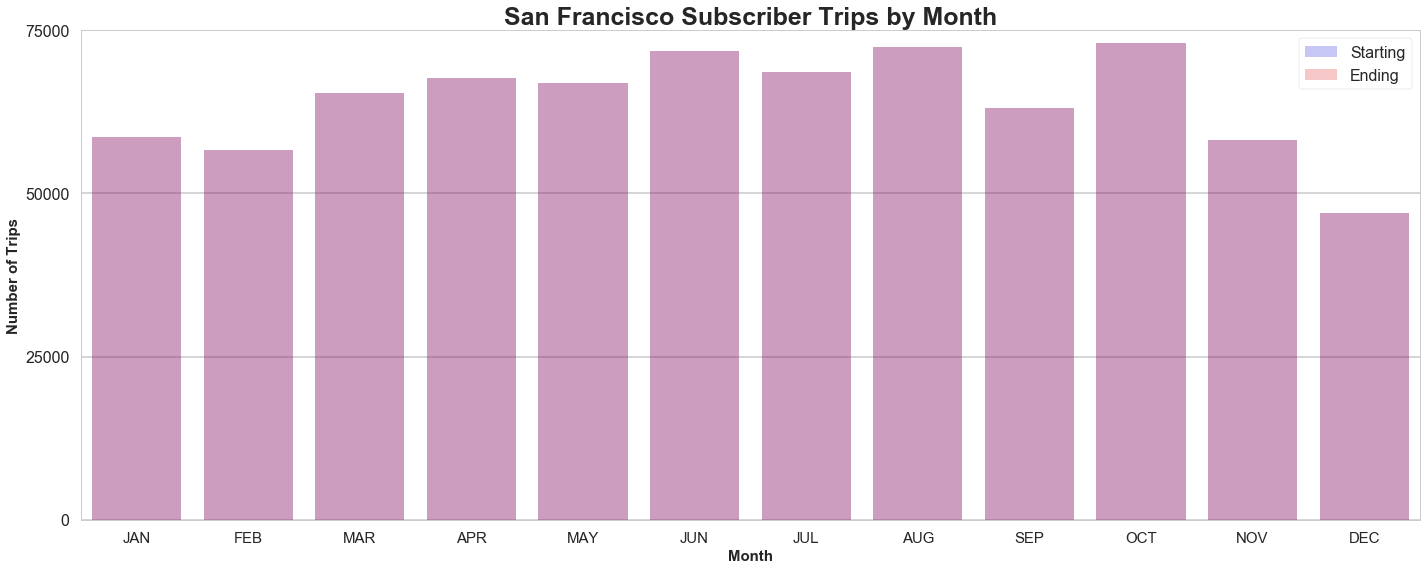

4.464


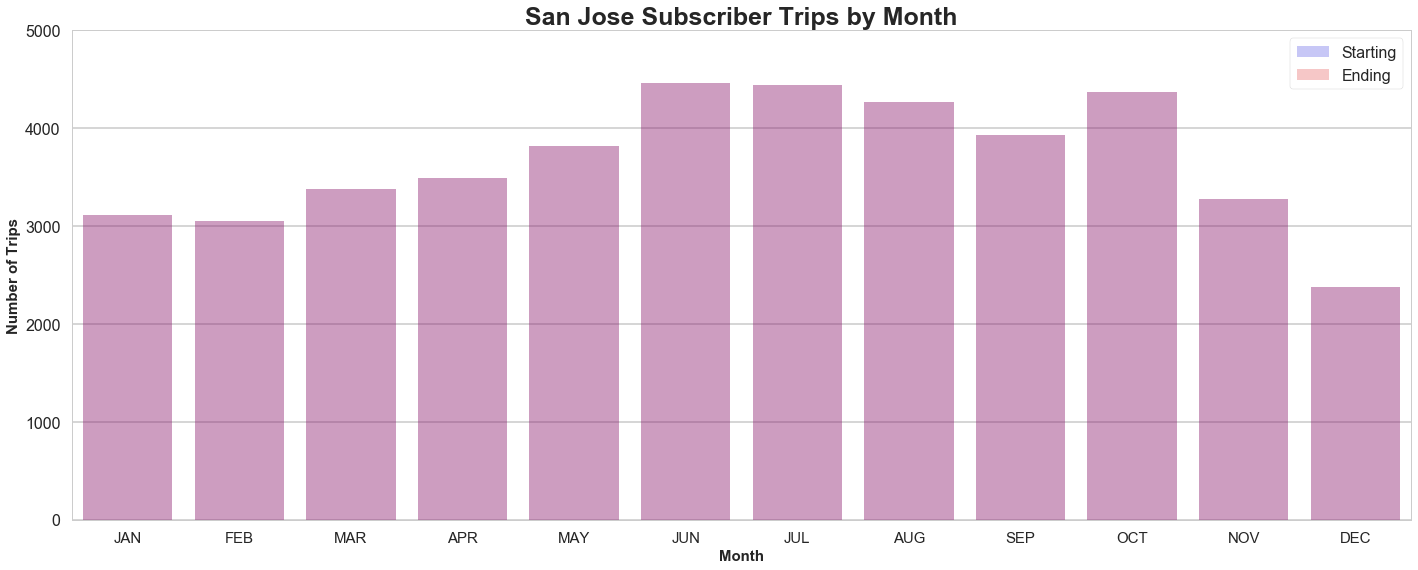

2.238


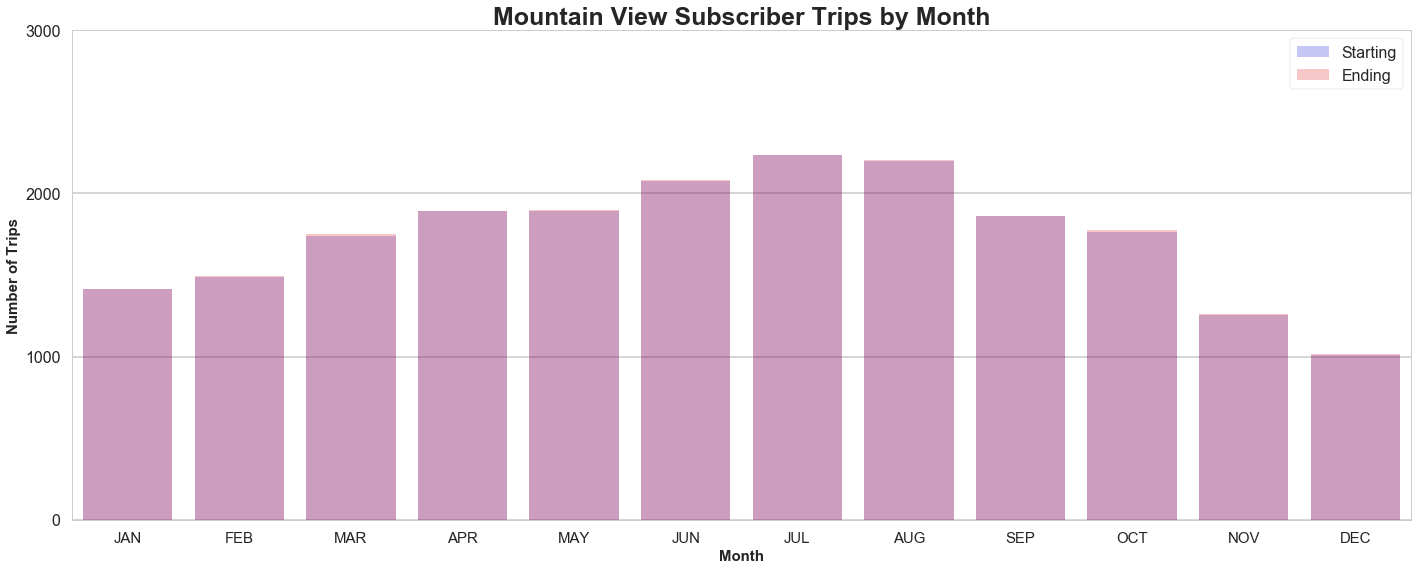

0.64


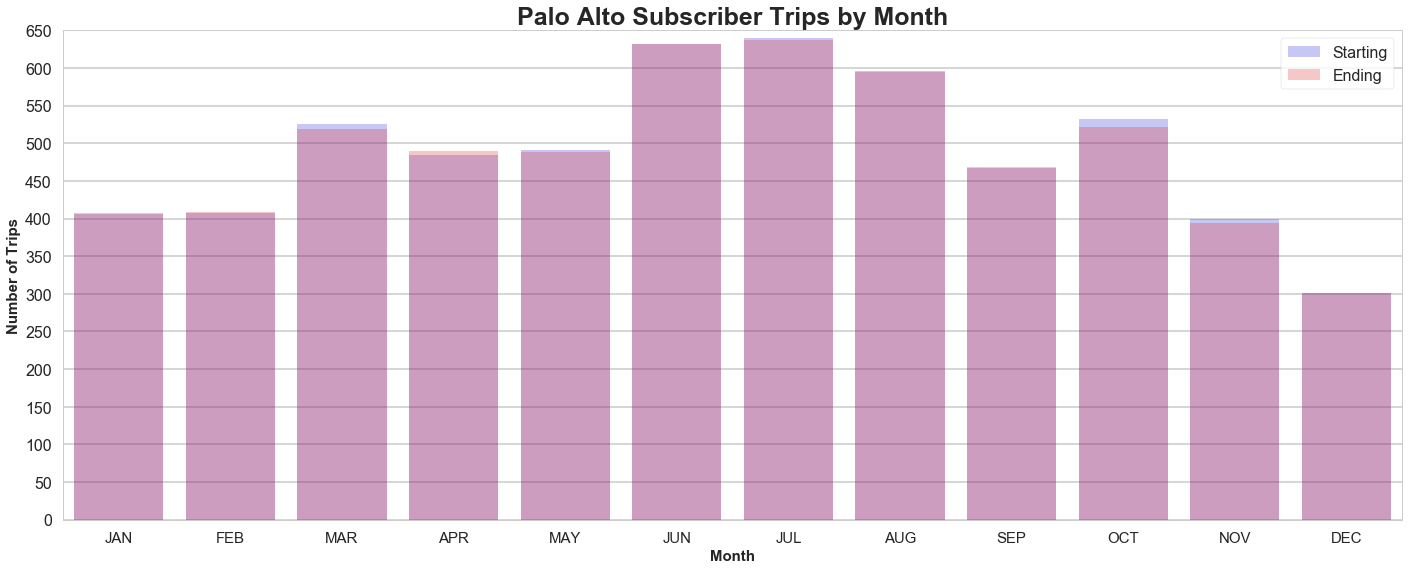

0.459


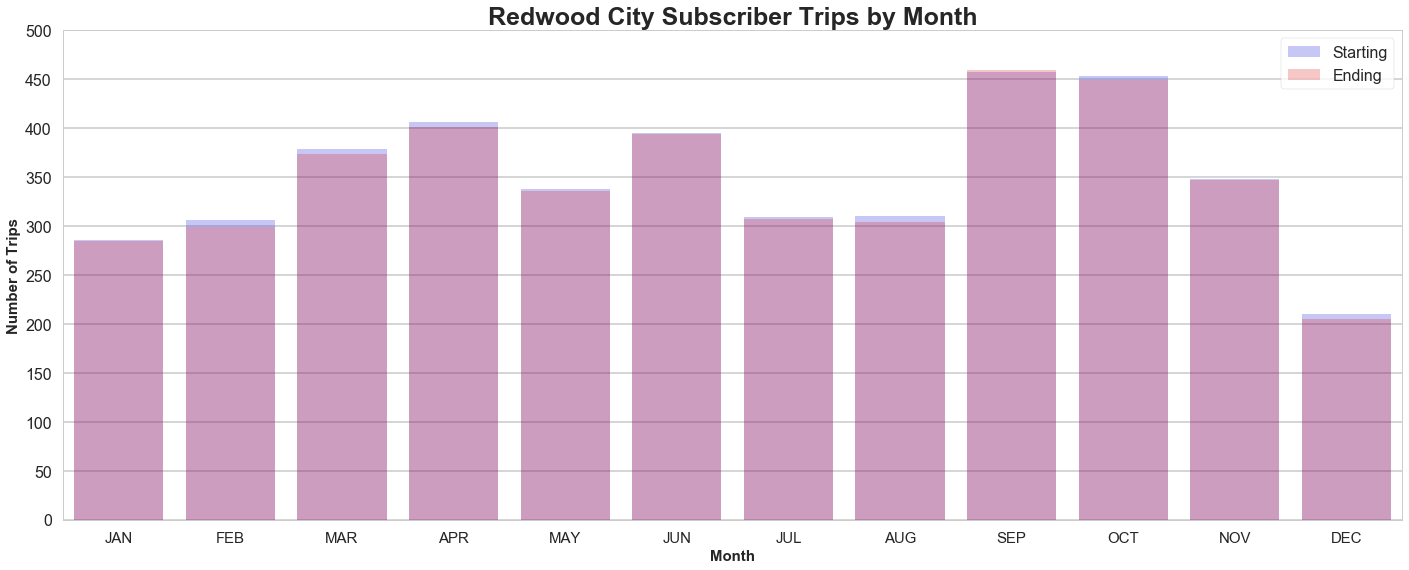

In [16]:
for zip_code in ordered_zipcodes:
    
    tmp_df = pd.DataFrame()
    
    subscriber_trips = trips_df[trips_df.user_type == 'Subscriber'].copy()
    
    starting_y = subscriber_trips[subscriber_trips.start_zip == zip_code].groupby(subscriber_trips[subscriber_trips.start_zip == zip_code].start_date.dt.month)['trip_id'].count()
    ending_y = subscriber_trips[subscriber_trips.end_zip == zip_code].groupby(subscriber_trips[subscriber_trips.end_zip == zip_code].end_date.dt.month)['trip_id'].count()
   
    tmp_df = pd.concat([starting_y, ending_y], axis=1)
    tmp_df = tmp_df.fillna(0)
    tmp_df.columns = ['starting', 'ending']
    tmp_df.starting = tmp_df.starting.astype('int')
    tmp_df.ending = tmp_df.ending.astype('int')
    
    tmp_df['starting_share'] = tmp_df.starting / tmp_df.starting.sum() * 100.
    tmp_df['ending_share'] = tmp_df.ending / tmp_df.ending.sum() * 100.
    
    # Trips by Hour by Customer Type
    plt.subplots(figsize=(24,9))

    ax = sns.barplot(x = month_labels , y = 'starting', data=tmp_df, color='b', alpha = 0.25, label='Starting')
    sns.barplot(x = month_labels , y = 'ending', data=tmp_df, color='r', alpha = 0.25, label='Ending', ax=ax)

    
    title = '%s Subscriber Trips by Month' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

    ax.set_xlabel('Month', size=LABEL_FONT_SIZE, weight='bold')
    
    ax.set_xticklabels(month_labels, size=TICK_FONT_SIZE*1.5)
    
    # set y axis
    y_interval = tmp_df.max().max()/1000
    print(y_interval)

    
    if y_interval > 30:
        y_interval = 25000
    elif y_interval < 10  and y_interval > 2:
        y_interval = 1000
    else:
        y_interval = 50
        
    y_max = -np.inf
    y_max = tmp_df.max().max()
    y_max = math.ceil(y_max/y_interval) * y_interval
    
    ax.set_ylim([0, y_max])
    ax.set_yticks([y for y in range(0, y_max+y_interval, y_interval)])
    ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')

    ax.legend(loc=1, frameon=True)
    
    image_title = '../charts/investigation_trips/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)
    plt.show()

## Subscriber Trips by Day of Week in each Region - Commute Hours Only
<ul>
    <li>Morning Commute Hours are 7am-10pm</li>
    <li>Evening Commute Hours are 4pm-7pm</li>
</ul>

weekday commute start share    98.4884
weekend commute start share    1.5116
weekday commute end share      98.4884
weekend commute end share      1.5116


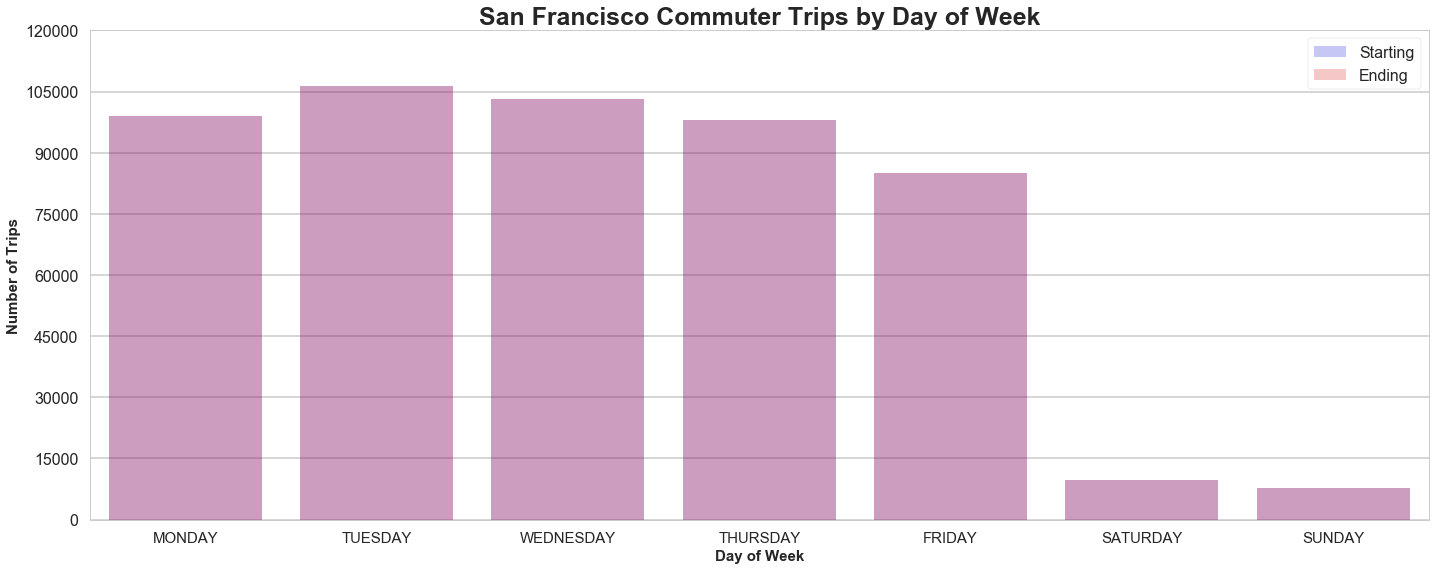

weekday commute start share    97.7713
weekend commute start share    2.2287
weekday commute end share      97.7713
weekend commute end share      2.2287


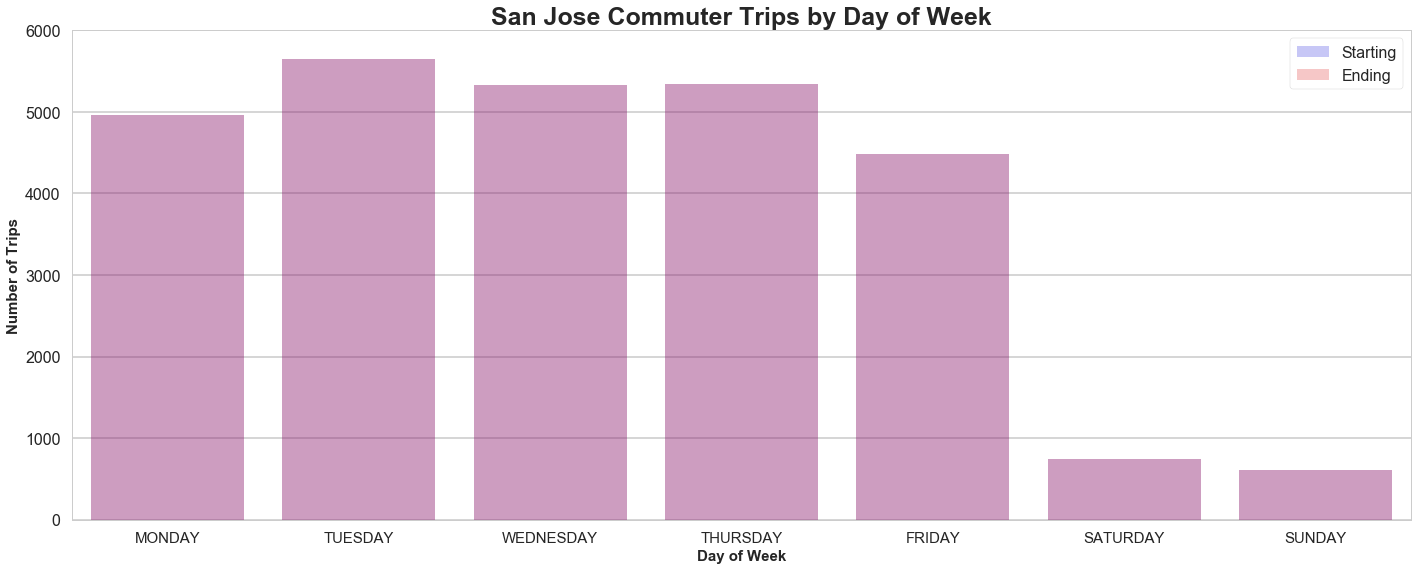

weekday commute start share    99.0678
weekend commute start share    0.9322
weekday commute end share      99.0821
weekend commute end share      0.9179


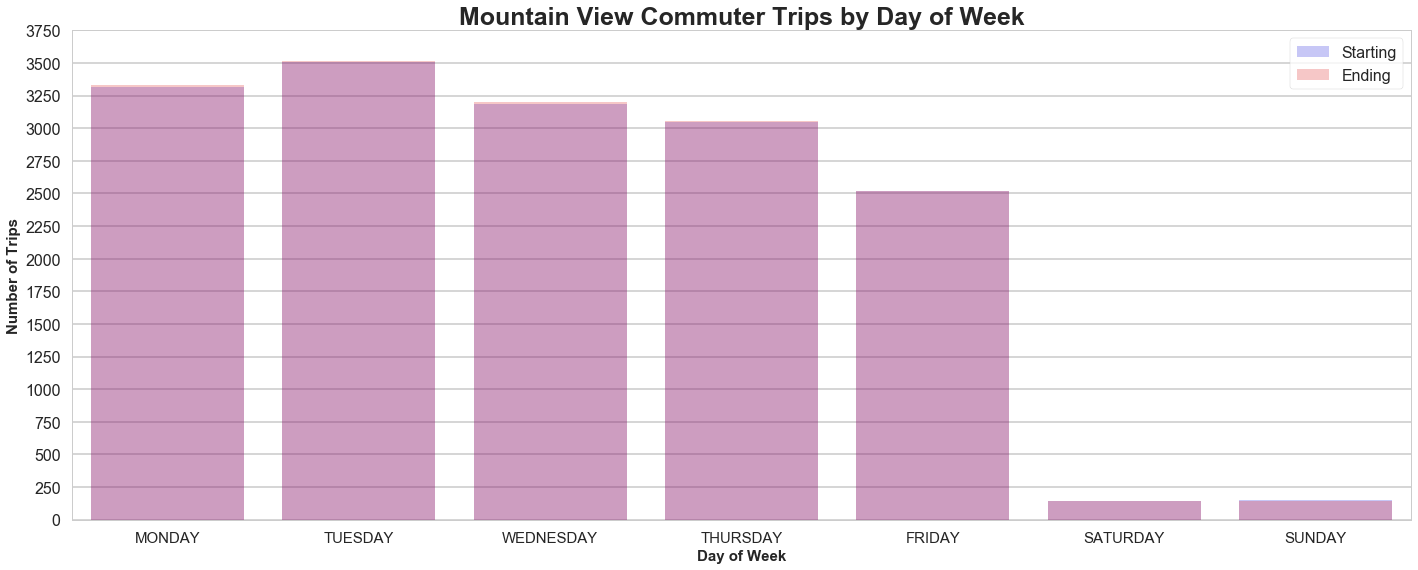

weekday commute start share    98.1027
weekend commute start share    1.8973
weekday commute end share      98.0568
weekend commute end share      1.9432


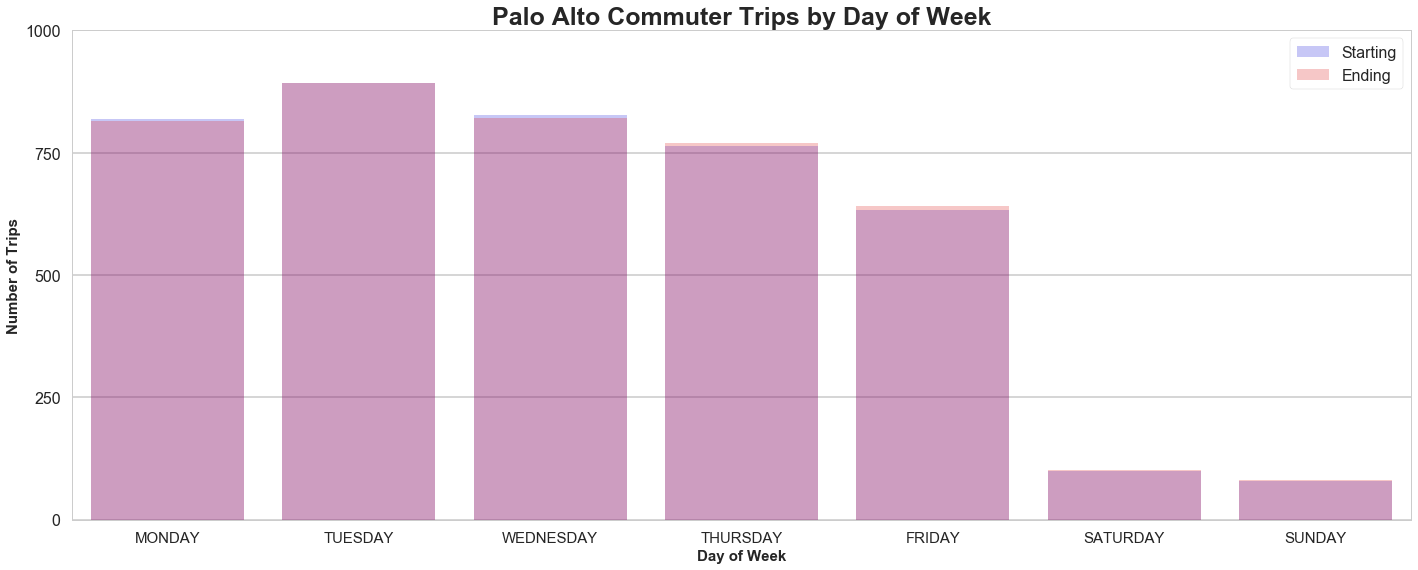

weekday commute start share    98.9416
weekend commute start share    1.0584
weekday commute end share      98.9292
weekend commute end share      1.0708


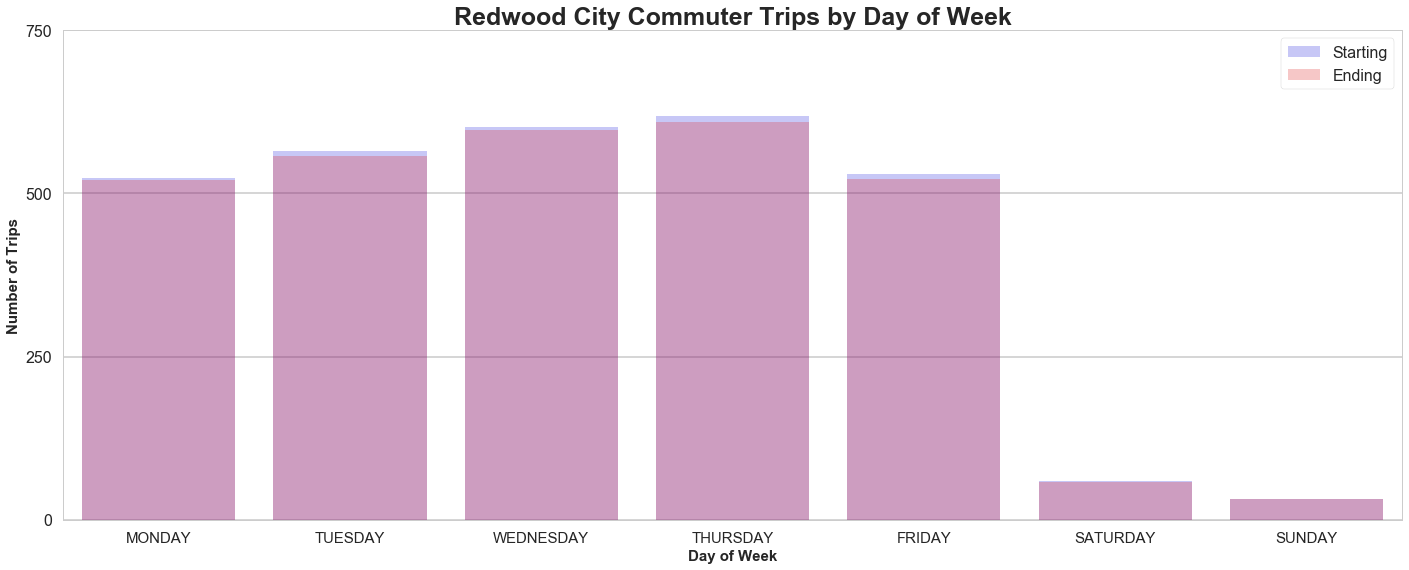

In [17]:
for zip_code in ordered_zipcodes:
    
    tmp_df = pd.DataFrame()
    
    subscriber_trips = trips_df[trips_df.user_type == 'Subscriber'].copy()
    
    commuter_trips = subscriber_trips[((subscriber_trips.start_date.dt.hour >= 7) & (subscriber_trips.start_date.dt.hour < 10)) | 
                                      ((subscriber_trips.end_date.dt.hour >= 7) & (subscriber_trips.end_date.dt.hour < 10)) | 
                                      ((subscriber_trips.start_date.dt.hour >= 16) & (subscriber_trips.start_date.dt.hour < 19)) | 
                                      ((subscriber_trips.end_date.dt.hour >= 16) & (subscriber_trips.end_date.dt.hour < 19))]
    
    starting_y = commuter_trips[commuter_trips.start_zip == zip_code].groupby(commuter_trips[commuter_trips.start_zip == zip_code].start_date.dt.dayofweek)['trip_id'].count()
    ending_y = commuter_trips[commuter_trips.end_zip == zip_code].groupby(commuter_trips[commuter_trips.end_zip == zip_code].end_date.dt.dayofweek)['trip_id'].count()
   
    tmp_df = pd.concat([starting_y, ending_y], axis=1)
    tmp_df = tmp_df.fillna(0)
    tmp_df.columns = ['starting', 'ending']
    tmp_df.starting = tmp_df.starting.astype('int')
    tmp_df.ending = tmp_df.ending.astype('int')
    
    tmp_df['starting_share'] = tmp_df.starting / tmp_df.starting.sum() * 100.
    tmp_df['ending_share'] = tmp_df.ending / tmp_df.ending.sum() * 100.
    
#     print(tmp_df[['starting_share', 'ending_share']])
    
    weekday_commute_start_share = tmp_df.iloc[0:6,2].sum()
    weekend_commute_start_share = tmp_df.iloc[6:,2].sum()
    print('weekday commute start share    {:2.4f}'.format(weekday_commute_start_share))
    print('weekend commute start share    {:2.4f}'.format(weekend_commute_start_share))

    
    weekday_commute_end_share = tmp_df.iloc[0:6,3].sum()
    weekend_commute_end_share = tmp_df.iloc[6:,3].sum()
    print('weekday commute end share      {:2.4f}'.format(weekday_commute_end_share))
    print('weekend commute end share      {:2.4f}'.format(weekend_commute_end_share))
    
    # Trips by Hour by Customer Type
    plt.subplots(figsize=(24,9))

    ax = sns.barplot(x = day_labels_full , y = 'starting', data=tmp_df, color='b', alpha = 0.25, label='Starting')
    sns.barplot(x = day_labels_full , y = 'ending', data=tmp_df, color='r', alpha = 0.25, label='Ending', ax=ax)

    
    title = '%s Commuter Trips by Day of Week' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

    ax.set_xlabel('Day of Week', size=LABEL_FONT_SIZE, weight='bold')
    
    ax.set_xticklabels(day_labels_full, size=TICK_FONT_SIZE*1.5)
    
    # set y axis
    y_interval = tmp_df.max().max()/5000

    
    if y_interval > 10:
        y_interval = 15000
    elif y_interval < 10  and y_interval > 1:
        y_interval = 1000
    else:
        y_interval = 250
        
    y_max = -np.inf
    y_max = tmp_df.max().max()
    y_max = math.ceil(y_max/y_interval) * y_interval
    
    ax.set_ylim([0, y_max])
    ax.set_yticks([y for y in range(0, y_max+y_interval, y_interval)])
    ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')

    ax.legend(loc=1, frameon=True)
    
    image_title = '../charts/investigation_trips/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)
    plt.show()

## Subscriber Trips by Hour of Day in each Region - Weekdays Only
<ul>
    <li>Morning Commute Hours are 7am-10pm</li>
    <li>Evening Commute Hours are 4pm-7pm</li>
</ul>

morning commute start share    34.1338
evening commute start share    31.5742
  total commute start share    65.7080
morning commute end share      33.5586
evening commute end share      31.6794
  total commute end share      65.2380


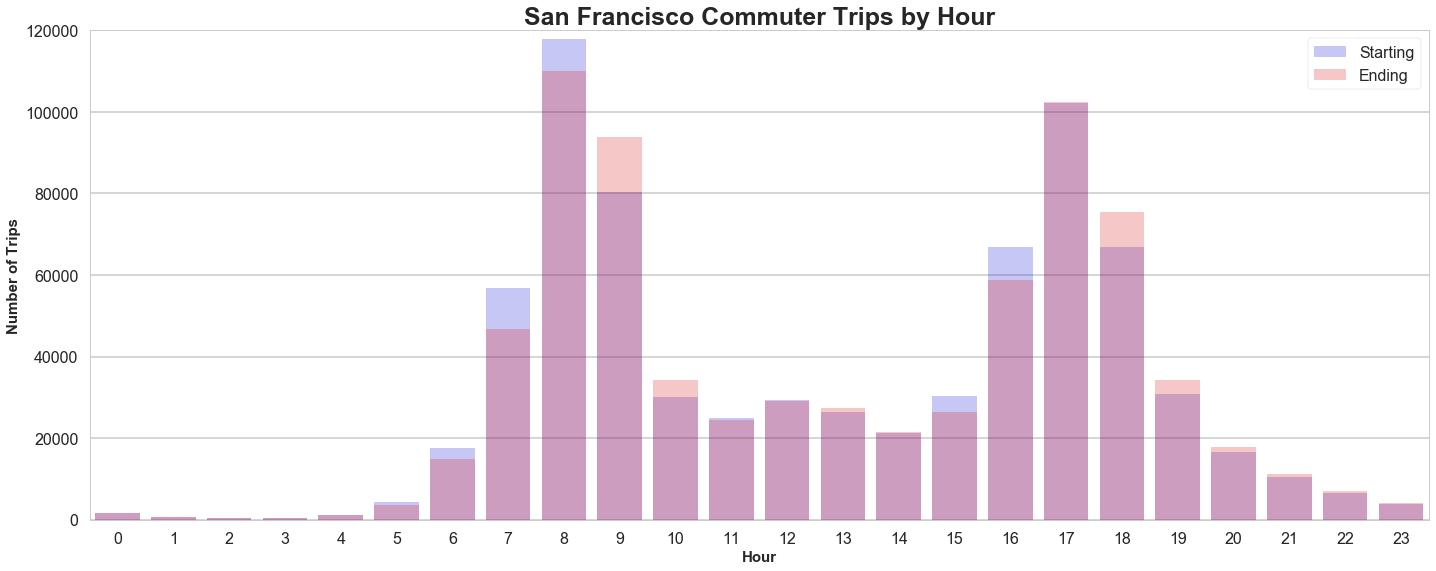

morning commute start share    27.8430
evening commute start share    33.7206
  total commute start share    61.5635
morning commute end share      28.2167
evening commute end share      33.7253
  total commute end share      61.9421


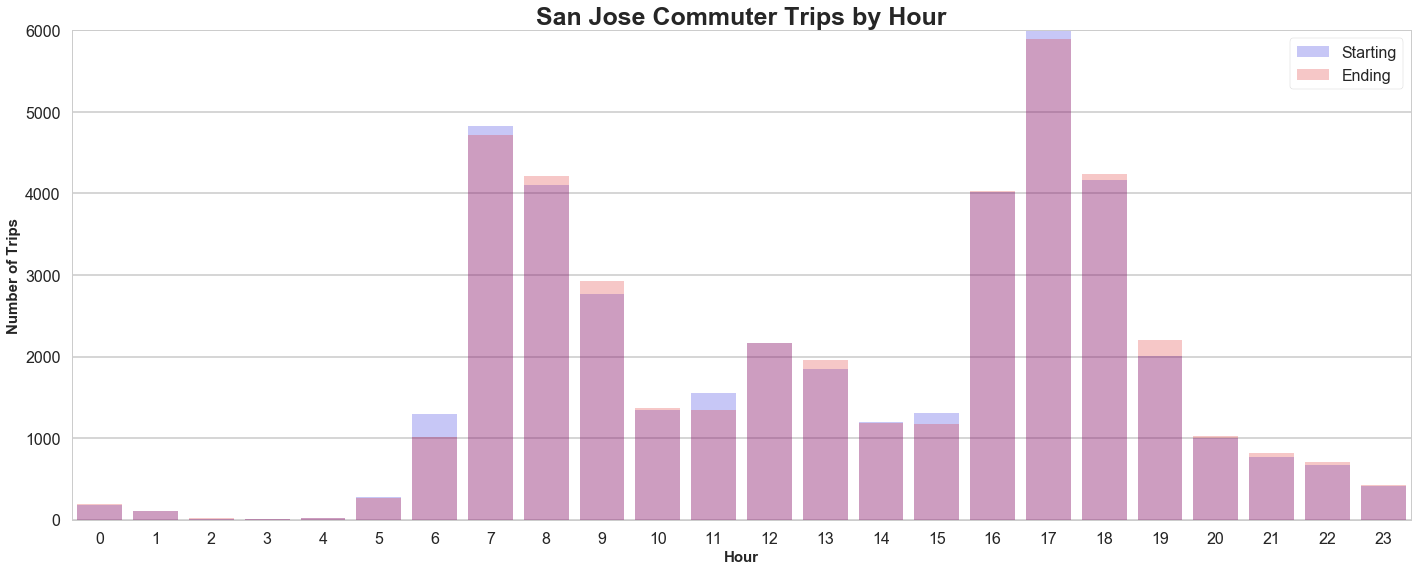

morning commute start share    39.7899
evening commute start share    36.4176
  total commute start share    76.2075
morning commute end share      39.2990
evening commute end share      35.7940
  total commute end share      75.0930


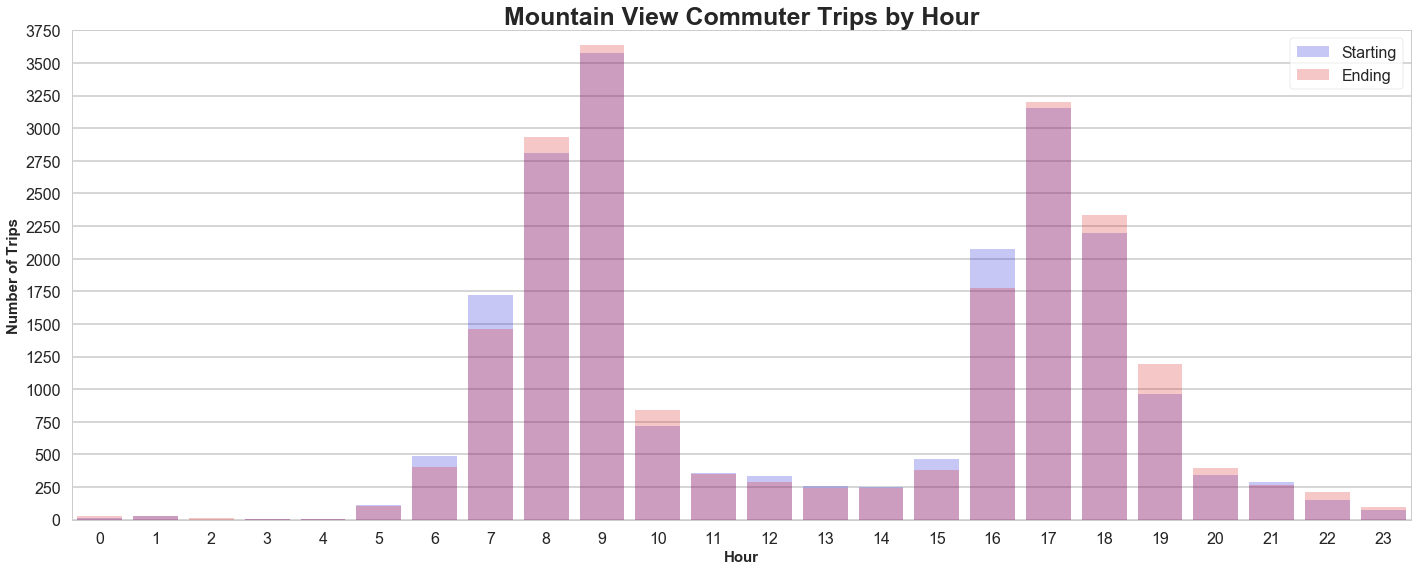

morning commute start share    36.5871
evening commute start share    33.7931
  total commute start share    70.3802
morning commute end share      35.3912
evening commute end share      33.4753
  total commute end share      68.8664


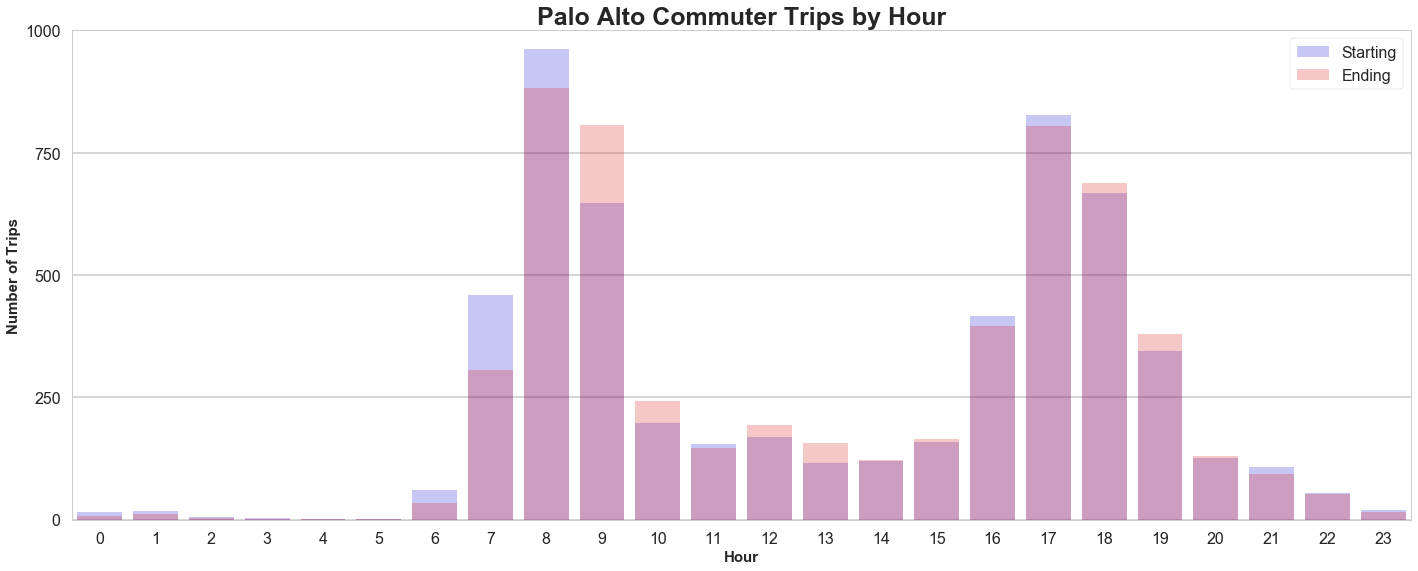

morning commute start share    36.5188
evening commute start share    33.5202
  total commute start share    70.0390
morning commute end share      37.9242
evening commute end share      31.7511
  total commute end share      69.6754


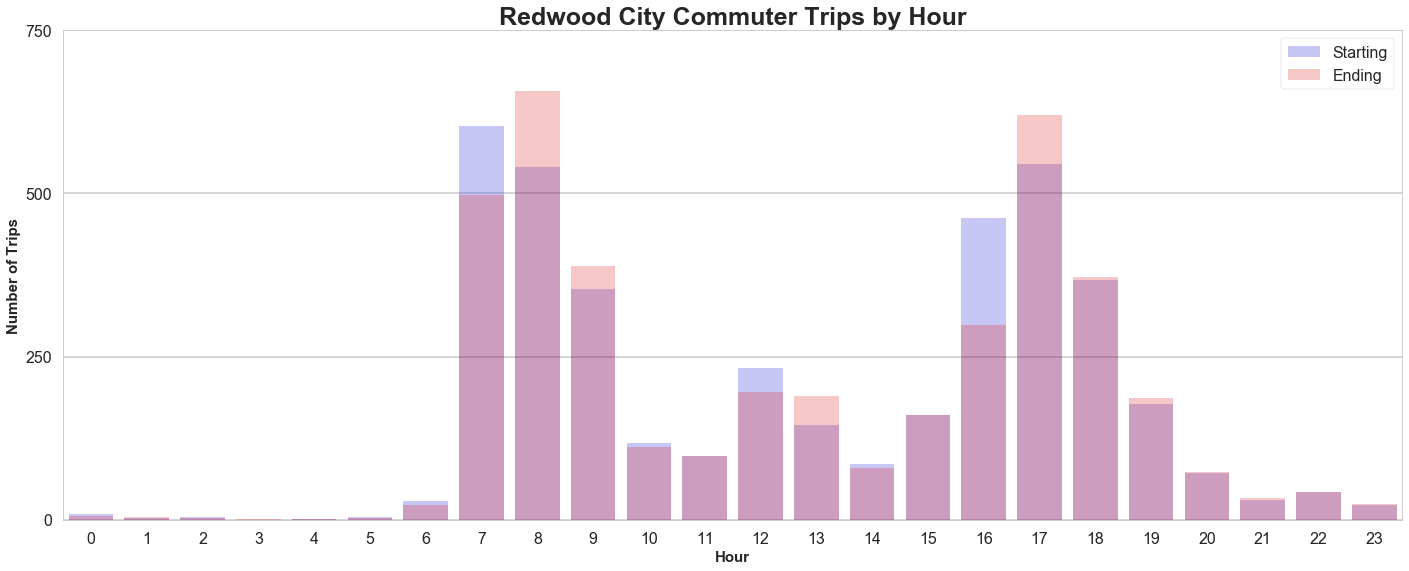

In [18]:
for zip_code in ordered_zipcodes:
    
    tmp_df = pd.DataFrame()
    
    subscriber_trips = trips_df[trips_df.user_type == 'Subscriber'].copy()
    
    commuter_trips = subscriber_trips[(subscriber_trips.start_date.dt.dayofweek < 6) & (subscriber_trips.end_date.dt.dayofweek < 6)]
    
    starting_y = commuter_trips[commuter_trips.start_zip == zip_code].groupby(commuter_trips[commuter_trips.start_zip == zip_code].start_date.dt.hour)['trip_id'].count()
    ending_y = commuter_trips[commuter_trips.end_zip == zip_code].groupby(commuter_trips[commuter_trips.end_zip == zip_code].end_date.dt.hour)['trip_id'].count()
        
    tmp_df = pd.concat([starting_y, ending_y], axis=1)
    tmp_df = tmp_df.fillna(0)
    tmp_df.columns = ['starting', 'ending']
    tmp_df.starting = tmp_df.starting.astype('int')
    tmp_df.ending = tmp_df.ending.astype('int')
    
    tmp_df['starting_share'] = tmp_df.starting / tmp_df.starting.sum() * 100.
    tmp_df['ending_share'] = tmp_df.ending / tmp_df.ending.sum() * 100.
    
    morning_commute_start_share = tmp_df.iloc[7:10,2].sum()
    evening_commute_start_share = tmp_df.iloc[16:19,2].sum()
    commute_start_share = morning_commute_start_share + evening_commute_start_share
    print('morning commute start share    {:2.4f}'.format(morning_commute_start_share))
    print('evening commute start share    {:2.4f}'.format(evening_commute_start_share))
    print('  total commute start share    {:2.4f}'.format(commute_start_share))

    
    morning_commute_end_share = tmp_df.iloc[7:10,3].sum()
    evening_commute_end_share = tmp_df.iloc[16:19,3].sum()
    commute_end_share = morning_commute_end_share + evening_commute_end_share
    print('morning commute end share      {:2.4f}'.format(morning_commute_end_share))
    print('evening commute end share      {:2.4f}'.format(evening_commute_end_share))
    print('  total commute end share      {:2.4f}'.format(commute_end_share))

    
    x_ticks = [x for x in range(0, tmp_df.shape[0])]
    
    # Trips by Hour by Customer Type
    plt.subplots(figsize=(24,9))

    ax = sns.barplot(x = x_ticks , y = 'starting', data=tmp_df, color='b', alpha = 0.25, label='Starting')
    sns.barplot(x = x_ticks , y = 'ending', data=tmp_df, color='r', alpha = 0.25, label='Ending', ax=ax)
    
    title = '%s Commuter Trips by Hour' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

    ax.set_xlabel('Hour', size=LABEL_FONT_SIZE, weight='bold')

    
    # set y axis
    y_interval = tmp_df.max().max()/5000
    
    if y_interval > 10:
        y_interval = 20000
    elif y_interval <= 10 and y_interval > 1:
        y_interval = 1000
    else:
        y_interval = 250

    y_max = -np.inf
    y_max = tmp_df.max().max()
    y_max = math.ceil(y_max/y_interval) * y_interval
    
    ax.set_ylim([0, y_max])
    ax.set_yticks([y for y in range(0, y_max+y_interval, y_interval)])
    ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')

    ax.legend(loc=1, frameon=True)
    
    image_title = '../charts/investigation_trips/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)
    plt.show()